In [14]:
import cvxpy as cp
import numpy as np

# ---------- Problem size ----------
N = 9  # i in [9] = {1,...,9}

# ---------- Parameters (22nm CMOS) ----------
beta_n = 3.9e-3     # A/V^2
beta_p = 1.38e-3    # A/V^2
lam    = 0.05       # channel length modulation λ
Vth    = 0.5        # V_th
RL     = 10e3       # load resistor 10 kΩ
A_req  = 500.0      # required minimum gain
Vov_min = 0.1       # minimum overdrive voltage 0.1 V

# Size bounds (all i share same bounds; 可以按需要改成向量)
W_min = 12e-9       # 12 nm
W_max = 10e-3       # 10 mm
L_min = 15e-9       # 15 nm
L_max = 10e-3       # 10 mm

# ---------- Decision variables (all positive for GP) ----------
I    = cp.Variable(N,  pos=True, name="I")        # I_i
Vov  = cp.Variable(N,  pos=True, name="Vov")      # V_{ov,i}
dV   = cp.Variable(N,  pos=True, name="dV")       # ΔV_i
s    = cp.Variable(N,  pos=True, name="s")        # s_i
W    = cp.Variable(N,  pos=True, name="W")        # W_i
L    = cp.Variable(N,  pos=True, name="L")        # L_i
Vdd  = cp.Variable(pos=True, name="Vdd")          # V_dd

constraints = []
ineqs = []   # (name, lhs, rhs, constraint) for all inequality constraints

# ---------- Basic constraints ----------

# W_i / (L_i s_i) = 1   (monomial equality)
for i in range(N):
    constraints.append(W[i] * (L[i] * s[i])**-1 == 1)

# Vdd / 12 <= 1  -> Vdd <= 12
lhs = Vdd
rhs = 12.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("Vdd_max", lhs, rhs, c))

# Width bounds:  W_min <= W_i <= W_max   (写成GP友好的形式)
for i in range(N):
    # W_min / W_i <= 1
    lhs = W_min * W[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    # ineqs.append((f"W_min_{i}", lhs, rhs, c))

    # W_i / W_max <= 1
    lhs = W[i] * (W_max**-1)
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    # ineqs.append((f"W_max_{i}", lhs, rhs, c))

# Length bounds: L_min <= L_i <= L_max
for i in range(N):
    # L_min / L_i <= 1
    lhs = L_min * L[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    # ineqs.append((f"L_min_{i}", lhs, rhs, c))

    # L_i / L_max <= 1
    lhs = L[i] * (L_max**-1)
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    # ineqs.append((f"L_max_{i}", lhs, rhs, c))

# ---------- Current constraints ----------

# Sets of indices (convert 1-based {1,...,9} -> 0-based python)
idx_n = [0, 1, 4, 5, 6]      # i in {1,2,5,6,7}  -> NMOS
idx_p = [2, 3, 7, 8]         # i in {3,4,8,9}   -> PMOS

# (1/2) β_{n/p} s_i Vov_i^2 (1 + λ(Vov[i] + ΔV[i])) I_i^{-1} <= 1,  i in [9]
for i in idx_n:
    lhs = 0.5 * beta_n * s[i] * Vov[i]**2 * (1 + lam*(Vov[i] + dV[i])) * I[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"I{i}_def_n", lhs*I[i], I[i], c))

for i in idx_p:
    lhs = 0.5 * beta_p * s[i] * Vov[i]**2 * (1 + lam*(Vov[i] + dV[i])) * I[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"I{i}_def_p", lhs*I[i], I[i], c))

# (I1 + I2) / I6 <= 1  -> (I[0] + I[1]) * I[5]^{-1} <= 1
lhs = (I[0] + I[1]) * I[5]**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("I12_over_I6", lhs, rhs, c))

# I_i / I_i' = 1 for specified pairs (convert to monomial equalities)
current_equal_pairs = [(8, 4), (0, 2), (1, 3), (6, 7)]
for i, j in current_equal_pairs:
    constraints.append(I[i] * I[j]**-1 == 1)

# ---------- Voltage equalities ----------

# ΔV_i = V_th, i in {3,5,9} -> 0-based {2,4,8}
for i in [2, 4, 8]:
    constraints.append(dV[i] == Vth)

# Vov,5 = Vov,6 = Vov,7 -> indices 4,5,6
constraints.append(Vov[4] == Vov[5])
constraints.append(Vov[5] == Vov[6])

# Vov,1 = Vov,2 -> indices 0,1
constraints.append(Vov[0] == Vov[1])

# Vov,3 = Vov,4 -> indices 2,3
constraints.append(Vov[2] == Vov[3])

# ---------- Vdd-related inequalities ----------

# ---------- Width and Length matching constraints ----------

# W1 = W2 -> indices 0,1
constraints.append(W[0] * W[1]**-1 == 1)

# W3 = W4 -> indices 2,3
constraints.append(W[2] * W[3]**-1 == 1)

# L1 = L2 -> indices 0,1
constraints.append(L[0] * L[1]**-1 == 1)

# L3 = L4 -> indices 2,3
constraints.append(L[2] * L[3]**-1 == 1)

# Overdrive voltage bounds: Vov_i >= Vov_min
for i in range(N):
    # Vov_min / Vov_i <= 1
    lhs = Vov_min * Vov[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"Vov_min_{i}", Vov[i], Vov_min, c))

# 2(Vov2 + Vov4 + dV2 + dV4) / Vdd <= 1
lhs = 2*(Vov[1] + Vov[3] + dV[1] + dV[3]) * Vdd**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("swing_1", lhs, rhs, c))

# (Vov7 + Vov8 + dV7 + dV8) / Vdd <= 1
lhs = (Vov[6] + Vov[7] + dV[6] + dV[7]) * Vdd**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("swing_2", lhs, rhs, c))

# 2(Vov1 + Vov6 + dV6 + Vth) / Vdd <= 1
lhs = 2*(Vov[0] + Vov[5] + dV[5] + Vth) * Vdd**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("swing_3", lhs, rhs, c))

# 2(dV2 + Vov8) / Vdd <= 1
lhs = 2*(dV[1] + Vov[7]) * Vdd**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("swing_4", lhs, rhs, c))

# 2(dV1 + Vov3) / Vdd <= 1
lhs = 2*(dV[0] + Vov[2]) * Vdd**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("swing_5", lhs, rhs, c))

# ---------- Gain constraint ----------
# A_req (λ I2 + λ I4)(λ I7 + λ I8 + 1/RL) / (β_n β_p s1 s8 Vov1 Vov8) <= 1
num = A_req * (lam*I[1] + lam*I[3]) * (lam*I[6] + lam*I[7] + 1.0/RL)
den = beta_n * beta_p * s[0] * s[7] * Vov[0] * Vov[7]
lhs = num * den**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("gain", (den*A_req)/num, A_req, c))

# ---------- 辅助约束（改成 GP 合法形式） ----------
# I[i] >= 0.0001  ->  0.01 * I[i]^{-1} <= 1
LOWER_BOUND = 0.0001
for i in range(N):
    lhs = LOWER_BOUND * I[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"I_min_{i}", I[i], LOWER_BOUND, c))

# Vdd >= 0.01 -> 0.01 * Vdd^{-1} <= 1
lhs =Vdd**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("Vdd_min", Vdd, LOWER_BOUND, c))

# dV bounds: dV_i >= dV_min to ensure V_DS > Vov (saturation)
dV_min = 0.001  # minimum dV value to ensure saturation
for i in range(N):
    # dV_min / dV_i <= 1
    lhs = dV_min * dV[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"dV_min_{i}", dV[i], dV_min, c))
# ---------- Objective ----------
# min sum_{i in {5,6,8}} I_i * Vdd  -> indices {4,5,7}  (1-based 5,6,8)
obj = cp.Minimize((I[4] + I[5] + I[7]) * Vdd)

problem = cp.Problem(obj, constraints)

# ---------- Solve as a Geometric Program ----------
problem.solve(gp=True)   # 可以根据环境加 solver=cp.MOSEK 等

print("status  :", problem.status)
print("optimal value :", problem.value)
print("Vdd*       :", Vdd.value)
print("I*         :", I.value)
print("Vov*       :", Vov.value)
print("dV*        :", dV.value)
print("s*         :", s.value)
print("W*         :", W.value)
print("L*         :", L.value)

# ---------- 打印每个不等式约束的左右两边数值 ----------
if problem.status in ["optimal", "optimal_inaccurate"]:
    print("\n===== Inequality constraints (lhs, rhs, active?) =====\n")
    for name, lhs, rhs, c in ineqs:
        lhs_val = lhs.value
        rhs_val = rhs if np.isscalar(rhs) else rhs.value
        # 有些可能是数组（但这里我们都是标量），保险起见处理一下
        lhs_val_float = float(np.max(lhs_val))
        rhs_val_float = float(np.max(rhs_val))
        active = np.isclose(lhs_val_float, rhs_val_float, atol=1e-4)
        print(f"{name:15s}:  lhs = {lhs_val_float:.4e},  rhs = {rhs_val_float:.4e},  active = {active}")
else:
    print("\nNo optimal solution; cannot evaluate inequality sides.")

# ---------- Reconstruct terminal voltages V_i1, V_i2, V_i3 ----------
print("\n===== Reconstructed Terminal Voltages (Following Circuit Topology) =====\n")

V1 = np.zeros(N)  # V_i1 (source)
V2 = np.zeros(N)  # V_i2 (gate)
V3 = np.zeros(N)  # V_i3 (drain)

# Ground reference
V_SS = 0.0
V_DD = Vdd.value

# Step 1: M6 (tail current source) - source at ground
V1[5] = V_SS  # M6 source
V2[5] = V1[5] + Vov.value[5] + Vth  # M6 gate
V3[5] = V1[5] + Vov.value[5] + dV.value[5]  # M6 drain

# Step 2: M1 and M2 (differential pair) - sources connected to M6 drain
V_tail = V3[5]  # common source node
V1[0] = V_tail  # M1 source
V1[1] = V_tail  # M2 source
V2[0] = V1[0] + Vov.value[0] + Vth  # M1 gate (Vi-)
V2[1] = V1[1] + Vov.value[1] + Vth  # M2 gate (Vi+)
V3[0] = V1[0] + Vov.value[0] + dV.value[0]  # M1 drain
V3[1] = V1[1] + Vov.value[1] + dV.value[1]  # M2 drain

# Step 3: M3 and M4 (active loads) - sources at Vdd
V1[2] = V_DD  # M3 source
V1[3] = V_DD  # M4 source
V3[2] = V1[2] - Vov.value[2] - dV.value[2]  # M3 drain
V3[3] = V1[3] - Vov.value[3] - dV.value[3]  # M4 drain
V2[2] = V1[2] - Vov.value[2] - Vth  # M3 gate
V2[3] = V1[3] - Vov.value[3] - Vth  # M4 gate

# Step 4: M5 (current mirror reference, diode-connected) - source at ground
V1[4] = V_SS  # M5 source
V3[4] = V1[4] + Vov.value[4] + dV.value[4]  # M5 drain
V2[4] = V3[4]  # M5 gate = M5 drain (diode-connected)

# Step 5: M9 (current mirror) - source at Vdd, gate connected to M5
V1[8] = V_DD  # M9 source
V2[8] = V2[4]  # M9 gate = M5 gate = M5 drain
V3[8] = V1[8] - Vov.value[8] - dV.value[8]  # M9 drain

# Step 6: M7 (output NMOS) - source at ground, gate connected to M4 drain
V1[6] = V_SS  # M7 source
V2[6] = V3[3]  # M7 gate = M4 drain = M2 drain
V3[6] = V1[6] + Vov.value[6] + dV.value[6]  # M7 drain

# Step 7: M8 (output PMOS) - source at Vdd, gate connected to M4 drain
V1[7] = V_DD  # M8 source
V2[7] = V3[3]  # M8 gate = M4 drain = M2 drain
V3[7] = V1[7] - Vov.value[7] - dV.value[7]  # M8 drain

# Output voltage (should be V3[6] = V3[7])
V_out = V3[6]  # or V3[7], they should be equal

print("Transistor  V_i1 (source)   V_i2 (gate)   V_i3 (drain)   Type      Description")
print("-" * 90)
descriptions = [
    "M1 (diff pair left)",
    "M2 (diff pair right)",
    "M3 (active load left)",
    "M4 (active load right)",
    "M5 (current mirror ref)",
    "M6 (tail current)",
    "M7 (output NMOS)",
    "M8 (output PMOS)",
    "M9 (current mirror)"
]
for i in range(N):
    transistor_type = "NMOS" if i in idx_n else "PMOS"
    print(f"    {i+1:1d}      {V1[i]:8.4f}       {V2[i]:8.4f}      {V3[i]:8.4f}      {transistor_type}    {descriptions[i]}")

print(f"\nOutput voltage V_o: {V_out:.4f} V")
print(f"Supply voltage V_DD: {V_DD:.4f} V")
print(f"Common source (tail): {V_tail:.4f} V")

# Check key node equalities
print("\n===== Circuit Node Consistency Checks =====\n")
print(f"M1 source = M2 source = M6 drain: {V1[0]:.4f} = {V1[1]:.4f} = {V3[5]:.4f}")
print(f"M4 drain = M2 drain = M7 gate = M8 gate: {V3[3]:.4f} = {V3[1]:.4f} = {V2[6]:.4f} = {V2[7]:.4f}")
print(f"M5 gate = M5 drain = M9 gate: {V2[4]:.4f} = {V3[4]:.4f} = {V2[8]:.4f}")
print(f"M7 drain = M8 drain (output): {V3[6]:.4f} = {V3[7]:.4f}")
print(f"M3 drain = M1 drain = M9 drain: {V3[2]:.4f} = {V3[0]:.4f} = {V3[8]:.4f}")

# Verify the relationships
print("\n===== Verification of Voltage Relationships =====\n")
print("Transistor  Vov (calc)   Vov (opt)   dV (calc)   dV (opt)   Match?")
print("-" * 75)
for i in range(N):
    if i in idx_n:
        # NMOS: Vov_i = V_i2 - V_i1 - Vth, dV_i = (V_i3 - V_i1) - Vov_i
        Vov_calc = V2[i] - V1[i] - Vth
        dV_calc = (V3[i] - V1[i]) - Vov_calc
    else:
        # PMOS: Vov_i = V_i1 - V_i2 - Vth, dV_i = (V_i1 - V_i3) - Vov_i
        Vov_calc = V1[i] - V2[i] - Vth
        dV_calc = (V1[i] - V3[i]) - Vov_calc
    
    Vov_match = np.isclose(Vov_calc, Vov.value[i], atol=1e-6)
    dV_match = np.isclose(dV_calc, dV.value[i], atol=1e-6)
    match_str = "✓" if (Vov_match and dV_match) else "✗"
    
    print(f"    {i+1:1d}       {Vov_calc:8.4f}    {Vov.value[i]:8.4f}   {dV_calc:8.4f}   {dV.value[i]:8.4f}    {match_str}")

status  : optimal
optimal value : 0.0005608000031035511
Vdd*       : 1.4020000026160881
I*         : [0.0001 0.0001 0.0001 0.0001 0.0001 0.0002 0.0001 0.0001 0.0001]
Vov*       : [0.1        0.1        0.13352858 0.13352858 0.1        0.1
 0.1        0.1068036  0.28893683]
dV*        : [0.00935963 0.00729094 0.5        0.00915962 0.5        0.001
 0.01383743 0.00974632 0.5       ]
s*         : [2.46519888e+00 2.46519888e+00 3.06847362e-02 3.06847362e-02
 1.70006575e-02 5.22938254e-02 2.79133297e-02 8.37702605e+00
 6.53918000e-03]
W*         : [1.83412583e-05 1.83412583e-05 1.97583334e-06 1.97583334e-06
 1.46536663e-06 2.59429842e-06 1.88508264e-06 3.34294058e-05
 9.05002025e-07]
L*         : [7.44007246e-06 7.44007246e-06 6.43914070e-05 6.43914070e-05
 8.61947037e-05 4.96100333e-05 6.75334210e-05 3.99060545e-06
 1.38396867e-04]

===== Inequality constraints (lhs, rhs, active?) =====

Vdd_max        :  lhs = 1.4020e+00,  rhs = 1.2000e+01,  active = False
I0_def_n       :  lhs = 4.8334e-

Vds formulation

In [ ]:
import cvxpy as cp
import numpy as np

# ---------- Problem size ----------
N = 9  # i in [9] = {1,...,9}

# ---------- Parameters (22nm CMOS) ----------
beta_n = 3.9e-3     # A/V^2
beta_p = 1.38e-3    # A/V^2
lam    = 0.05       # channel length modulation λ
Vth    = 0.5        # V_th
RL     = 10e3       # load resistor 10 kΩ
A_req  = 500.0      # required minimum gain
Vov_min = 0.1       # minimum overdrive voltage 0.1 V

# Size bounds
W_min = 12e-9       # 12 nm
W_max = 10e-3       # 10 mm
L_min = 15e-9       # 15 nm
L_max = 10e-3       # 10 mm

# ---------- Decision variables (all positive for GP) ----------
I    = cp.Variable(N,  pos=True, name="I")        # I_i
Vov  = cp.Variable(N,  pos=True, name="Vov")      # V_{ov,i}
Vds  = cp.Variable(N,  pos=True, name="Vds")      # V_{ds,i}
s    = cp.Variable(N,  pos=True, name="s")        # s_i
W    = cp.Variable(N,  pos=True, name="W")        # W_i
L    = cp.Variable(N,  pos=True, name="L")        # L_i
Vdd  = cp.Variable(pos=True, name="Vdd")          # V_dd

constraints = []
ineqs = []

# Sets of indices (convert 1-based {1,...,9} -> 0-based python)
idx_n = [0, 1, 4, 5, 6]      # i in {1,2,5,6,7}  -> NMOS
idx_p = [2, 3, 7, 8]         # i in {3,4,8,9}   -> PMOS

# ---------- Basic constraints ----------

# W_i / (L_i s_i) = 1   (monomial equality)
for i in range(N):
    constraints.append(W[i] * (L[i] * s[i])**-1 == 1)

# Vdd bounds
lhs = Vdd
rhs = 12.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("Vdd_max", lhs, rhs, c))

lhs = 0.01 * Vdd**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("Vdd_min", Vdd, 0.01, c))

# Width bounds
for i in range(N):
    lhs = W_min * W[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    
    lhs = W[i] * (W_max**-1)
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)

# Length bounds
for i in range(N):
    lhs = L_min * L[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    
    lhs = L[i] * (L_max**-1)
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)

# Width and Length matching
constraints.append(W[0] * W[1]**-1 == 1)  # W1 = W2
constraints.append(W[2] * W[3]**-1 == 1)  # W3 = W4
constraints.append(L[0] * L[1]**-1 == 1)  # L1 = L2
constraints.append(L[2] * L[3]**-1 == 1)  # L3 = L4

# M1 drain = M3 drain = M9 drain
# V_13 = Vds_6 + Vds_1 = Vdd - Vds_3
# constraints.append((Vds[0] + Vds[2] + Vds[5]) * Vdd**-1 == 1)

# # M2 drain = M4 drain  
# # Vds_2 + Vds_4 + Vds_6 = Vdd
# constraints.append((Vds[1] + Vds[3] + Vds[5]) * Vdd**-1 == 1)

# # Output node: V_73 = V_83
# # Vds_7 + Vds_8 = Vdd
# constraints.append((Vds[6] + Vds[7]) * Vdd**-1 == 1)

# # M7 gate = M4 drain
# # Vov_7 + Vth = Vdd - Vds_4
# constraints.append((Vov[6] + Vth) * (Vdd - Vds[3])**-1 == 1)

# # M8 gate = M4 drain
# # Vov_8 + Vth = Vds_4
# constraints.append((Vov[7] + Vth) * Vds[3]**-1 == 1)

# # M5 diode: Vov_5 + Vth = Vds_5
# constraints.append((Vov[4] + Vth) * Vds[4]**-1 == 1)

# ---------- Current constraints ----------

# Current definition: I_i >= (1/2) β s_i Vov_i^2 (1 + λ Vds_i)
for i in idx_n:
    lhs = 0.5 * beta_n * s[i] * Vov[i]**2 * (1 + lam*Vds[i]) * I[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"I{i}_def_n", lhs*I[i], I[i], c))

for i in idx_p:
    lhs = 0.5 * beta_p * s[i] * Vov[i]**2 * (1 + lam*Vds[i]) * I[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"I{i}_def_p", lhs*I[i], I[i], c))

# *** Vov_min constraints: Vov_i >= Vov_min (0.1V) ***
for i in range(N):
    lhs = Vov_min * Vov[i]**-1
    c = lhs <= 1.0
    constraints.append(c)
    ineqs.append((f"Vov_min_{i}", Vov[i], Vov_min, c))

# Current equality
current_equal_pairs = [(8, 4), (0, 2), (1, 3), (6, 7)]
for i, j in current_equal_pairs:
    constraints.append(I[i] * I[j]**-1 == 1)

# Tail current: (I1 + I2) / I6 <= 1
# lhs = (I[0] + I[1]) * I[5]**-1
# rhs = 1.0
# c = lhs <= rhs
# constraints.append(c)
# ineqs.append(("I12_over_I6", lhs, rhs, c))

constraints.append(2 * I[0] * I[5]**-1 == 1)  # I1 = 1/2I6
constraints.append(2 * I[1] * I[5]**-1 == 1)  # I2 = 1/2I6

# Current lower bound
LOWER_BOUND = 0.00001
for i in range(N):
    lhs = LOWER_BOUND * I[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"I_min_{i}", I[i], LOWER_BOUND, c))

# ---------- Voltage constraints ----------

# Vov equalities
constraints.append(Vov[4] == Vov[5])  # Vov5 = Vov6
constraints.append(Vov[5] == Vov[6])  # Vov6 = Vov7
constraints.append(Vov[0] == Vov[1])  # Vov1 = Vov2
constraints.append(Vov[2] == Vov[3])  # Vov3 = Vov4

# Saturation constraint: Vov_i / Vds_i <= 1  (ensures transistor in saturation)
for i in range(N):
    lhs = Vov[i] * Vds[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"sat_{i}", Vov[i], Vds[i], c))

# Vov lower bound
for i in range(N):
    lhs = Vov_min * Vov[i]**-1
    rhs = 1.0
    c = lhs <= rhs
    constraints.append(c)
    ineqs.append((f"Vov_min_{i}", Vov[i], Vov_min, c))

# Vds lower bound
# Vds_min = Vov_min + 0.01
# for i in range(N):
#     lhs = Vds_min * Vds[i]**-1
#     rhs = 1.0
#     c = lhs <= rhs
#     constraints.append(c)
#     ineqs.append((f"Vds_min_{i}", Vds[i], Vds_min, c))


# ---------- Swing constraints ----------

# 2(Vds2 + Vds4) / Vdd <= 1
# lhs = 2*(Vds[1] + Vds[3]) * Vdd**-1
# rhs = 1.0
# c = lhs <= rhs
# constraints.append(c)
# ineqs.append(("swing_1", lhs, rhs, c))

# # (Vds7 + Vds8) / Vdd <= 1
# lhs = (Vds[6] + Vds[7]) * Vdd**-1
# rhs = 1.0
# c = lhs <= rhs
# constraints.append(c)
# ineqs.append(("swing_2", lhs, rhs, c))

# # 2(Vov1 + Vds6 + Vth) / Vdd <= 1
# lhs = 2*(Vov[0] + Vds[5] + Vth) * Vdd**-1
# rhs = 1.0
# c = lhs <= rhs
# constraints.append(c)
# ineqs.append(("swing_3", lhs, rhs, c))

# ---------- Gain constraint ----------
num = A_req * (lam*I[1] + lam*I[3]) * (lam*I[6] + lam*I[7] + 1.0/RL)
den = beta_n * beta_p * s[0] * s[7] * Vov[0] * Vov[7]
lhs = num * den**-1
rhs = 1.0
c = lhs <= rhs
constraints.append(c)
ineqs.append(("gain", (den*A_req)/num, A_req, c))

# ---------- Objective ----------
obj = cp.Minimize((I[4] + I[5] + I[7]) * Vdd)

problem = cp.Problem(obj, constraints)

# ---------- Solve ----------
print("Solving GP...")
problem.solve(gp=True, verbose=False)

print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)
print(f"Status: {problem.status}")
print(f"Optimal Power: {problem.value:.6e} W")
print(f"Vdd: {Vdd.value:.4f} V\n")

# ---------- Print results ----------
if problem.status in ["optimal", "optimal_inaccurate"]:
    print("-"*80)
    print("CURRENTS (A)")
    print("-"*80)
    for i in range(N):
        print(f"I{i+1}: {I.value[i]:.6e}")
    
    print("\n" + "-"*80)
    print("VOLTAGES (V)")
    print("-"*80)
    print(f"{'Trans':<6} {'Vov':<10} {'Vds':<10} {'dV=Vds-Vov':<12}")
    print("-"*50)
    for i in range(N):
        dV_val = Vds.value[i] - Vov.value[i]
        print(f"M{i+1:<5} {Vov.value[i]:10.4f} {Vds.value[i]:10.4f} {dV_val:12.4f}")
    
    print("\n" + "-"*80)
    print("SIZING")
    print("-"*80)
    print(f"{'Trans':<6} {'W (um)':<12} {'L (nm)':<12} {'s (factor)':<12} {'W/L':<12}")
    print("-"*60)
    for i in range(N):
        W_um = W.value[i] * 1e6
        L_nm = L.value[i] * 1e9
        WL_ratio = W.value[i] / L.value[i]
        print(f"M{i+1:<5} {W_um:12.4f} {L_nm:12.2f} {s.value[i]:12.4e} {WL_ratio:12.2f}")
    
    # ---------- Active constraints ----------
    print("\n" + "="*80)
    print("ACTIVE CONSTRAINTS (binding at optimum)")
    print("="*80)
    for name, lhs, rhs, c in ineqs:
        lhs_val = lhs.value
        rhs_val = rhs if np.isscalar(rhs) else rhs.value
        lhs_val_float = float(np.max(lhs_val))
        rhs_val_float = float(np.max(rhs_val))
        active = np.isclose(lhs_val_float, rhs_val_float, atol=1e-4)
        if active:
            print(f"{name:15s}: {lhs_val_float:.4e} = {rhs_val_float:.4e} ✓")
    
    # ---------- Node voltage reconstruction ----------
    print("\n" + "="*80)
    print("NODE VOLTAGES (reconstructed from circuit topology)")
    print("="*80)
    
    V1 = np.zeros(N)
    V2 = np.zeros(N)
    V3 = np.zeros(N)
    
    V_SS = 0.0
    V_DD = Vdd.value
    
    # M6 (tail) - source at ground
    V1[5] = V_SS
    V2[5] = V1[5] + Vov.value[5] + Vth
    V3[5] = V1[5] + Vds.value[5]
    
    # M1, M2 (diff pair) - sources at tail
    V_tail = V3[5]
    V1[0] = V_tail
    V1[1] = V_tail
    V2[0] = V1[0] + Vov.value[0] + Vth
    V2[1] = V1[1] + Vov.value[1] + Vth
    V3[0] = V1[0] + Vds.value[0]
    V3[1] = V1[1] + Vds.value[1]
    
    # M3, M4 (active loads) - sources at Vdd
    V1[2] = V_DD
    V1[3] = V_DD
    V3[2] = V1[2] - Vds.value[2]
    V3[3] = V1[3] - Vds.value[3]
    V2[2] = V1[2] - Vov.value[2] - Vth
    V2[3] = V1[3] - Vov.value[3] - Vth
    
    # M5 (current mirror ref) - source at ground, diode-connected
    V1[4] = V_SS
    V3[4] = V1[4] + Vds.value[4]
    V2[4] = V3[4]
    
    # M9 (current mirror) - source at Vdd
    V1[8] = V_DD
    V2[8] = V2[4]  # gate tied to M5
    V3[8] = V1[8] - Vds.value[8]
    
    # M7 (output NMOS) - source at ground
    V1[6] = V_SS
    V2[6] = V3[3]  # gate = M4 drain
    V3[6] = V1[6] + Vds.value[6]
    
    # M8 (output PMOS) - source at Vdd
    V1[7] = V_DD
    V2[7] = V3[3]  # gate = M4 drain
    V3[7] = V1[7] - Vds.value[7]
    
    V_out = V3[6]
    
    descriptions = [
        "M1 (diff pair -)",
        "M2 (diff pair +)",
        "M3 (load left)",
        "M4 (load right)",
        "M5 (mirror ref)",
        "M6 (tail)",
        "M7 (out NMOS)",
        "M8 (out PMOS)",
        "M9 (mirror)"
    ]
    
    print(f"\n{'Trans':<7} {'Type':<5} {'V_S':<8} {'V_G':<8} {'V_D':<8} {'Description'}")
    print("-" * 70)
    for i in range(N):
        t_type = "NMOS" if i in idx_n else "PMOS"
        print(f"M{i+1:<6} {t_type:<5} {V1[i]:8.4f} {V2[i]:8.4f} {V3[i]:8.4f} {descriptions[i]}")
    
    print(f"\nOutput voltage: {V_out:.4f} V")
    print(f"Tail voltage:   {V_tail:.4f} V")
    
    # Verify node equalities
    print("\n" + "-"*80)
    print("Circuit Node Verification")
    print("-"*80)
    print(f"M1_S = M2_S = M6_D (tail):    {V1[0]:.4f} = {V1[1]:.4f} = {V3[5]:.4f}")
    print(f"M1_D = M3_D = M9_D:           {V3[0]:.4f} = {V3[2]:.4f} = {V3[8]:.4f}")
    print(f"M2_D = M4_D = M7_G = M8_G:    {V3[1]:.4f} = {V3[3]:.4f} = {V2[6]:.4f} = {V2[7]:.4f}")
    print(f"M5_G = M5_D = M9_G:           {V2[4]:.4f} = {V3[4]:.4f} = {V2[8]:.4f}")
    print(f"M7_D = M8_D (output):         {V3[6]:.4f} = {V3[7]:.4f}")
    
else:
    print("\nOptimization failed!")

Solving GP...

OPTIMIZATION RESULTS
Status: optimal
Optimal Power: 6.077549e-05 W
Vdd: 1.4200 V

--------------------------------------------------------------------------------
CURRENTS (A)
--------------------------------------------------------------------------------
I1: 1.000000e-05
I2: 1.000000e-05
I3: 1.000000e-05
I4: 1.000000e-05
I5: 1.000000e-05
I6: 2.000000e-05
I7: 1.279964e-05
I8: 1.279964e-05
I9: 1.000000e-05

--------------------------------------------------------------------------------
VOLTAGES (V)
--------------------------------------------------------------------------------
Trans  Vov        Vds        dV=Vds-Vov  
--------------------------------------------------
M1         0.1000     0.1100       0.0100
M2         0.1000     0.1100       0.0100
M3         0.1863     1.6796       1.4934
M4         0.1863     0.2386       0.0523
M5         0.1086     1.3332       1.2246
M6         0.1086     0.1100       0.0014
M7         0.1086     0.2411       0.1325
M8         0

In [21]:
import cvxpy as cp
import numpy as np

# ---------- Problem size ----------
N = 9  # i in [9] = {1,...,9}

# ---------- Parameters (22nm CMOS) ----------
beta_n = 3.9e-3     # A/V^2
beta_p = 1.38e-3    # A/V^2
lam    = 0.05       # channel length modulation λ
Vth    = 0.5        # V_th
RL     = 10e3       # load resistor 10 kΩ
A_req  = 500.0      # required minimum gain
Vov_min = 0.1       # minimum overdrive voltage 0.1 V

# Size bounds
W_min = 12e-9       # 12 nm
W_max = 10e-3       # 10 mm
L_min = 15e-9       # 15 nm
L_max = 10e-3       # 10 mm

# Sets of indices
idx_n = [0, 1, 4, 5, 6]      # NMOS
idx_p = [2, 3, 7, 8]         # PMOS

class CuttingPlaneConstraint:
    """Represents a constraint that should be approximately equal but is relaxed to inequality"""
    def __init__(self, name, lhs_func, target=1.0):
        self.name = name
        self.lhs_func = lhs_func  # Function that computes LHS given variables
        self.target = target      # Target value (usually 1.0)
        self.upper_bound = 1.0    # Current upper bound (tightens over iterations)
        
def build_problem(cp_constraints, vds_lower_bounds=None):
    """Build GP problem with cutting plane constraints"""
    
    # ---------- Decision variables ----------
    I    = cp.Variable(N,  pos=True, name="I")
    Vov  = cp.Variable(N,  pos=True, name="Vov")
    Vds  = cp.Variable(N,  pos=True, name="Vds")
    s    = cp.Variable(N,  pos=True, name="s")
    W    = cp.Variable(N,  pos=True, name="W")
    L    = cp.Variable(N,  pos=True, name="L")
    Vdd  = cp.Variable(pos=True, name="Vdd")
    
    constraints = []
    ineqs = []
    
    # ---------- Basic constraints ----------
    
    # W_i / (L_i s_i) = 1  (TRUE monomial equality ✓)
    for i in range(N):
        constraints.append(W[i] * (L[i] * s[i])**-1 == 1)
    
    # Vdd bounds
    lhs = Vdd * 12.0**-1
    c = lhs <= 1.0
    constraints.append(c)
    ineqs.append(("Vdd_max", lhs, 1.0, c))
    
    lhs = 0.01 * Vdd**-1
    c = lhs <= 1.0
    constraints.append(c)
    ineqs.append(("Vdd_min", Vdd, 0.01, c))
    
    # Width and Length bounds
    for i in range(N):
        constraints.append(W_min * W[i]**-1 <= 1.0)
        constraints.append(W[i] * W_max**-1 <= 1.0)
        constraints.append(L_min * L[i]**-1 <= 1.0)
        constraints.append(L[i] * L_max**-1 <= 1.0)
    
    # Matching constraints (TRUE monomial equalities ✓)
    constraints.append(W[0] * W[1]**-1 == 1)  # W1 = W2
    constraints.append(W[2] * W[3]**-1 == 1)  # W3 = W4
    constraints.append(L[0] * L[1]**-1 == 1)  # L1 = L2
    constraints.append(L[2] * L[3]**-1 == 1)  # L3 = L4
    
    # ---------- Current constraints ----------
    
    for i in idx_n:
        lhs = 0.5 * beta_n * s[i] * Vov[i]**2 * (1 + lam*Vds[i]) * I[i]**-1
        c = lhs <= 1.0
        constraints.append(c)
        ineqs.append((f"I{i}_def_n", lhs*I[i], I[i], c))
    
    for i in idx_p:
        lhs = 0.5 * beta_p * s[i] * Vov[i]**2 * (1 + lam*Vds[i]) * I[i]**-1
        c = lhs <= 1.0
        constraints.append(c)
        ineqs.append((f"I{i}_def_p", lhs*I[i], I[i], c))
    
    # Current equalities (TRUE monomial equalities ✓)
    current_equal_pairs = [(8, 4), (0, 2), (1, 3), (6, 7)]
    for i, j in current_equal_pairs:
        constraints.append(I[i] * I[j]**-1 == 1)
    
    # Tail current
    lhs = (I[0] + I[1]) * I[5]**-1
    c = lhs <= 1.0
    constraints.append(c)
    ineqs.append(("I12_over_I6", lhs, 1.0, c))
    
    # Current lower bounds
    for i in range(N):
        constraints.append(0.0001 * I[i]**-1 <= 1.0)
    
    # ---------- Voltage constraints ----------
    
    # Vov equalities (TRUE monomial equalities ✓)
    constraints.append(Vov[4] * Vov[5]**-1 == 1)  # Vov5 = Vov6
    constraints.append(Vov[5] * Vov[6]**-1 == 1)  # Vov6 = Vov7
    constraints.append(Vov[0] * Vov[1]**-1 == 1)  # Vov1 = Vov2
    constraints.append(Vov[2] * Vov[3]**-1 == 1)  # Vov3 = Vov4
    
    # Saturation: Vov/Vds <= 1
    for i in range(N):
        lhs = Vov[i] * Vds[i]**-1
        c = lhs <= 1.0
        constraints.append(c)
        ineqs.append((f"sat_{i}", Vov[i], Vds[i], c))
    
    # *** Vov_min constraints: Vov_i >= Vov_min (0.1V) ***
    for i in range(N):
        lhs = Vov_min * Vov[i]**-1
        c = lhs <= 1.0
        constraints.append(c)
        ineqs.append((f"Vov_min_{i}", Vov[i], Vov_min, c))
    
    # Vds lower bounds
    for i in range(N):
        # Base lower bound
        base_bound = Vov_min + 0.01
        # Apply cutting plane lower bounds if provided
        if vds_lower_bounds is not None and vds_lower_bounds[i] > base_bound:
            bound = vds_lower_bounds[i]
        else:
            bound = base_bound
        constraints.append(bound * Vds[i]**-1 <= 1.0)
    
    # ========== POSYNOMIAL CONSTRAINTS (RELAXED, WILL BE TIGHTENED) ==========
    
    # Store these for cutting plane iteration
    cp_constraint_list = []
    
    # M1 drain = M3 drain: Vds_1 + Vds_3 + Vds_6 = Vdd
    for cp_c in cp_constraints:
        if cp_c.name == "node_M1D=M3D":
            lhs = (Vds[0] + Vds[2] + Vds[5]) * Vdd**-1
            c = lhs <= cp_c.upper_bound
            constraints.append(c)
            ineqs.append((cp_c.name, lhs, cp_c.upper_bound, c))
            cp_c.lhs_func = lambda: (Vds[0] + Vds[2] + Vds[5]) * Vdd**-1
    
    # M1 drain = M9 drain: Vds_1 + Vds_9 + Vds_6 = Vdd
    for cp_c in cp_constraints:
        if cp_c.name == "node_M1D=M9D":
            lhs = (Vds[0] + Vds[8] + Vds[5]) * Vdd**-1
            c = lhs <= cp_c.upper_bound
            constraints.append(c)
            ineqs.append((cp_c.name, lhs, cp_c.upper_bound, c))
            cp_c.lhs_func = lambda: (Vds[0] + Vds[8] + Vds[5]) * Vdd**-1
    
    # M2 drain = M4 drain: Vds_2 + Vds_4 + Vds_6 = Vdd
    for cp_c in cp_constraints:
        if cp_c.name == "node_M2D=M4D":
            lhs = (Vds[1] + Vds[3] + Vds[5]) * Vdd**-1
            c = lhs <= cp_c.upper_bound
            constraints.append(c)
            ineqs.append((cp_c.name, lhs, cp_c.upper_bound, c))
            cp_c.lhs_func = lambda: (Vds[1] + Vds[3] + Vds[5]) * Vdd**-1
    
    # Output node: Vds_7 + Vds_8 = Vdd
    for cp_c in cp_constraints:
        if cp_c.name == "node_output":
            lhs = (Vds[6] + Vds[7]) * Vdd**-1
            c = lhs <= cp_c.upper_bound
            constraints.append(c)
            ineqs.append((cp_c.name, lhs, cp_c.upper_bound, c))
            cp_c.lhs_func = lambda: (Vds[6] + Vds[7]) * Vdd**-1
    
    # M7 gate: Vov_7 + Vth = Vdd - Vds_4
    for cp_c in cp_constraints:
        if cp_c.name == "gate_M7":
            lhs = (Vov[6] + Vth) * (Vdd - Vds[3])**-1
            c = lhs <= cp_c.upper_bound
            constraints.append(c)
            ineqs.append((cp_c.name, lhs, cp_c.upper_bound, c))
            cp_c.lhs_func = lambda: (Vov[6] + Vth) * (Vdd - Vds[3])**-1
    
    # M8 gate: Vov_8 + Vth = Vds_4
    for cp_c in cp_constraints:
        if cp_c.name == "gate_M8":
            lhs = (Vov[7] + Vth) * Vds[3]**-1
            c = lhs <= cp_c.upper_bound
            constraints.append(c)
            ineqs.append((cp_c.name, lhs, cp_c.upper_bound, c))
            cp_c.lhs_func = lambda: (Vov[7] + Vth) * Vds[3]**-1
    
    # M5 diode: Vov_5 + Vth = Vds_5
    for cp_c in cp_constraints:
        if cp_c.name == "diode_M5":
            lhs = (Vov[4] + Vth) * Vds[4]**-1
            c = lhs <= cp_c.upper_bound
            constraints.append(c)
            ineqs.append((cp_c.name, lhs, cp_c.upper_bound, c))
            cp_c.lhs_func = lambda: (Vov[4] + Vth) * Vds[4]**-1
    
    # M9 gate: Vov_9 + Vth + Vds_5 = Vdd
    for cp_c in cp_constraints:
        if cp_c.name == "gate_M9":
            lhs = (Vov[8] + Vth + Vds[4]) * Vdd**-1
            c = lhs <= cp_c.upper_bound
            constraints.append(c)
            ineqs.append((cp_c.name, lhs, cp_c.upper_bound, c))
            cp_c.lhs_func = lambda: (Vov[8] + Vth + Vds[4]) * Vdd**-1
    
    # ---------- Gain constraint ----------
    num = A_req * (lam*I[1] + lam*I[3]) * (lam*I[6] + lam*I[7] + 1.0/RL)
    den = beta_n * beta_p * s[0] * s[7] * Vov[0] * Vov[7]
    lhs = num * den**-1
    c = lhs <= 1.0
    constraints.append(c)
    ineqs.append(("gain", (den*A_req)/num, A_req, c))
    
    # ---------- Objective ----------
    obj = cp.Minimize((I[4] + I[5] + I[7]) * Vdd)
    
    problem = cp.Problem(obj, constraints)
    
    return problem, (I, Vov, Vds, s, W, L, Vdd), ineqs

def evaluate_constraint_slack(Vov_val, Vds_val, Vdd_val):
    """Evaluate how much slack each posynomial constraint has"""
    slacks = {}
    
    # M1 drain = M3 drain
    val = (Vds_val[0] + Vds_val[2] + Vds_val[5]) / Vdd_val
    slacks["node_M1D=M3D"] = 1.0 - val
    
    # M1 drain = M9 drain
    val = (Vds_val[0] + Vds_val[8] + Vds_val[5]) / Vdd_val
    slacks["node_M1D=M9D"] = 1.0 - val
    
    # M2 drain = M4 drain
    val = (Vds_val[1] + Vds_val[3] + Vds_val[5]) / Vdd_val
    slacks["node_M2D=M4D"] = 1.0 - val
    
    # Output node
    val = (Vds_val[6] + Vds_val[7]) / Vdd_val
    slacks["node_output"] = 1.0 - val
    
    # M7 gate
    if Vdd_val - Vds_val[3] > 0:
        val = (Vov_val[6] + Vth) / (Vdd_val - Vds_val[3])
        slacks["gate_M7"] = 1.0 - val
    else:
        slacks["gate_M7"] = 999
    
    # M8 gate
    val = (Vov_val[7] + Vth) / Vds_val[3]
    slacks["gate_M8"] = 1.0 - val
    
    # M5 diode
    val = (Vov_val[4] + Vth) / Vds_val[4]
    slacks["diode_M5"] = 1.0 - val
    
    # M9 gate
    val = (Vov_val[8] + Vth + Vds_val[4]) / Vdd_val
    slacks["gate_M9"] = 1.0 - val
    
    return slacks

# ========== MAIN CUTTING PLANE LOOP ==========

print("="*80)
print("GP WITH CUTTING PLANE FOR NODE VOLTAGE CONSTRAINTS")
print("="*80)
print("\nStrategy:")
print("1. Monomial equalities: Enforced exactly in GP")
print("2. Posynomial constraints: Initially relaxed to inequalities")
print("3. Cutting plane: Iteratively tighten upper bounds if slack is too large")
print("4. Vov_i >= 0.1V enforced for all transistors")
print("="*80)

# Initialize cutting plane constraints with relaxed upper bounds
cp_constraints = [
    CuttingPlaneConstraint("node_M1D=M3D", None, 1.0),
    CuttingPlaneConstraint("node_M1D=M9D", None, 1.0),
    CuttingPlaneConstraint("node_M2D=M4D", None, 1.0),
    CuttingPlaneConstraint("node_output", None, 1.0),
    CuttingPlaneConstraint("gate_M7", None, 1.0),
    CuttingPlaneConstraint("gate_M8", None, 1.0),
    CuttingPlaneConstraint("diode_M5", None, 1.0),
    CuttingPlaneConstraint("gate_M9", None, 1.0),
]

vds_lower_bounds = np.array([Vov_min + 0.01] * N)
max_iterations = 10
slack_tolerance = 0.01  # 1% slack is acceptable

for iteration in range(max_iterations):
    print(f"\n{'='*80}")
    print(f"Iteration {iteration + 1}")
    print(f"{'='*80}")
    
    # Print current upper bounds for cutting plane constraints
    print("\nCurrent constraint upper bounds:")
    for cp_c in cp_constraints:
        print(f"  {cp_c.name}: <= {cp_c.upper_bound:.4f}")
    
    # Build and solve problem
    problem, variables, ineqs = build_problem(cp_constraints, vds_lower_bounds)
    I, Vov, Vds, s, W, L, Vdd = variables
    
    problem.solve(gp=True, verbose=False)
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        print(f"\n✗ Optimization failed with status: {problem.status}")
        break
    
    print(f"\nStatus: {problem.status}")
    print(f"Power: {problem.value:.6e} W")
    print(f"Vdd: {Vdd.value:.4f} V")
    
    # Evaluate constraint slacks
    slacks = evaluate_constraint_slack(Vov.value, Vds.value, Vdd.value)
    
    print("\nConstraint slacks (target = 0):")
    max_slack = 0
    violations = []
    for name, slack in slacks.items():
        print(f"  {name}: {slack:+.6f}")
        if abs(slack) > slack_tolerance:
            violations.append((name, slack))
        max_slack = max(max_slack, abs(slack))
    
    # Check convergence
    if max_slack <= slack_tolerance:
        print(f"\n✓ Converged! Max slack = {max_slack:.6f} <= {slack_tolerance}")
        break
    else:
        print(f"\n→ Max slack = {max_slack:.6f} > {slack_tolerance}")
        print(f"  Adding cutting plane constraints...")
        
        # Tighten constraints
        for name, slack in violations:
            for cp_c in cp_constraints:
                if cp_c.name == name:
                    if slack > 0:  # Too much slack, tighten upper bound
                        # Reduce upper bound by 50% of the slack
                        new_bound = cp_c.upper_bound - 0.5 * slack
                        cp_c.upper_bound = max(0.95, new_bound)  # Don't go below 0.95
                        print(f"    Tightening {name}: {cp_c.upper_bound:.4f}")
                    elif slack < 0:  # Constraint violated (shouldn't happen with <=)
                        print(f"    Warning: {name} violated (shouldn't happen)")
        
        # Also adjust Vds lower bounds based on which node constraints are tight
        # This helps guide the solution toward feasibility
        if "node_M1D=M3D" in [v[0] for v in violations]:
            # Increase lower bounds on Vds1, Vds3, Vds6
            for idx in [0, 2, 5]:
                vds_lower_bounds[idx] = min(vds_lower_bounds[idx] * 1.05, 0.5)

# ========== FINAL RESULTS ==========

if problem.status in ["optimal", "optimal_inaccurate"]:
    print("\n" + "="*80)
    print("FINAL RESULTS")
    print("="*80)
    
    print("\nCURRENTS (A):")
    for i in range(N):
        print(f"  I{i+1}: {I.value[i]:.6e}")
    
    print("\nVOLTAGES:")
    print(f"{'Trans':<6} {'Vov (V)':<10} {'Vds (V)':<10} {'dV (V)':<10} {'Sat?':<5}")
    print("-"*50)
    for i in range(N):
        dV = Vds.value[i] - Vov.value[i]
        sat = "✓" if Vov.value[i] < Vds.value[i] else "✗"
        vov_ok = "✓" if Vov.value[i] >= Vov_min else "✗"
        print(f"M{i+1:<5} {Vov.value[i]:10.4f} {Vds.value[i]:10.4f} {dV:10.4f} {sat:<5} Vov>={Vov_min}: {vov_ok}")
    
    print("\nSIZING:")
    print(f"{'Trans':<6} {'W (um)':<12} {'L (nm)':<12} {'W/L':<10} {'s':<12}")
    print("-"*60)
    for i in range(N):
        print(f"M{i+1:<5} {W.value[i]*1e6:12.4f} {L.value[i]*1e9:12.2f} {W.value[i]/L.value[i]:10.2f} {s.value[i]:12.4e}")
    
    # Reconstruct node voltages for verification
    V1 = np.zeros(N)
    V2 = np.zeros(N)
    V3 = np.zeros(N)
    
    V_SS = 0.0
    V_DD = Vdd.value
    
    # M6
    V1[5] = V_SS
    V2[5] = V1[5] + Vov.value[5] + Vth
    V3[5] = V1[5] + Vds.value[5]
    
    # M1, M2
    V_tail = V3[5]
    V1[0] = V_tail
    V1[1] = V_tail
    V2[0] = V1[0] + Vov.value[0] + Vth
    V2[1] = V1[1] + Vov.value[1] + Vth
    V3[0] = V1[0] + Vds.value[0]
    V3[1] = V1[1] + Vds.value[1]
    
    # M3, M4
    V1[2] = V_DD
    V1[3] = V_DD
    V3[2] = V1[2] - Vds.value[2]
    V3[3] = V1[3] - Vds.value[3]
    V2[2] = V1[2] - Vov.value[2] - Vth
    V2[3] = V1[3] - Vov.value[3] - Vth
    
    # M5
    V1[4] = V_SS
    V3[4] = V1[4] + Vds.value[4]
    V2[4] = V3[4]
    
    # M9
    V1[8] = V_DD
    V2[8] = V2[4]
    V3[8] = V1[8] - Vds.value[8]
    
    # M7
    V1[6] = V_SS
    V2[6] = V3[3]
    V3[6] = V1[6] + Vds.value[6]
    
    # M8
    V1[7] = V_DD
    V2[7] = V3[3]
    V3[7] = V1[7] - Vds.value[7]
    
    print("\nNODE VOLTAGES:")
    descriptions = ["M1 (diff-)", "M2 (diff+)", "M3 (load)", "M4 (load)", 
                   "M5 (mirror)", "M6 (tail)", "M7 (out N)", "M8 (out P)", "M9 (mirror)"]
    print(f"{'Trans':<7} {'Type':<5} {'V_S':<8} {'V_G':<8} {'V_D':<8} {'Description'}")
    print("-"*70)
    for i in range(N):
        t_type = "NMOS" if i in idx_n else "PMOS"
        print(f"M{i+1:<6} {t_type:<5} {V1[i]:8.4f} {V2[i]:8.4f} {V3[i]:8.4f} {descriptions[i]}")
    
    print(f"\nOutput voltage: {V3[6]:.4f} V")
    print(f"Tail voltage:   {V_tail:.4f} V")
    
    # Node consistency checks
    print("\nNode Consistency Verification:")
    print(f"  M1_D = M3_D = M9_D: {V3[0]:.4f} = {V3[2]:.4f} = {V3[8]:.4f}  (err: {max(V3[0],V3[2],V3[8])-min(V3[0],V3[2],V3[8]):.4f})")
    print(f"  M2_D = M4_D:        {V3[1]:.4f} = {V3[3]:.4f}  (err: {abs(V3[1]-V3[3]):.4f})")
    print(f"  M7_D = M8_D:        {V3[6]:.4f} = {V3[7]:.4f}  (err: {abs(V3[6]-V3[7]):.4f})")
    print(f"  M5_G = M5_D:        {V2[4]:.4f} = {V3[4]:.4f}  (err: {abs(V2[4]-V3[4]):.4f})")
    
    # Show active constraints
    print("\nACTIVE/BINDING CONSTRAINTS:")
    for name, lhs, rhs, c in ineqs:
        lhs_val = float(np.max(lhs.value))
        rhs_val = float(np.max(rhs if np.isscalar(rhs) else rhs.value))
        if np.isclose(lhs_val, rhs_val, atol=1e-4):
            print(f"  {name}: {lhs_val:.4e} ≈ {rhs_val:.4e} ✓")

print("\n" + "="*80)

GP WITH CUTTING PLANE FOR NODE VOLTAGE CONSTRAINTS

Strategy:
1. Monomial equalities: Enforced exactly in GP
2. Posynomial constraints: Initially relaxed to inequalities
3. Cutting plane: Iteratively tighten upper bounds if slack is too large
4. Vov_i >= 0.1V enforced for all transistors

Iteration 1

Current constraint upper bounds:
  node_M1D=M3D: <= 1.0000
  node_M1D=M9D: <= 1.0000
  node_M2D=M4D: <= 1.0000
  node_output: <= 1.0000
  gate_M7: <= 1.0000
  gate_M8: <= 1.0000
  diode_M5: <= 1.0000
  gate_M9: <= 1.0000


DGPError: Problem does not follow DGP rules.The following constraints are not DGP:
W[0] * power(L[0] * s[0], -1.0) == 1.0 , because the following subexpressions are not:
W[1] * power(L[1] * s[1], -1.0) == 1.0 , because the following subexpressions are not:
W[2] * power(L[2] * s[2], -1.0) == 1.0 , because the following subexpressions are not:
W[3] * power(L[3] * s[3], -1.0) == 1.0 , because the following subexpressions are not:
W[4] * power(L[4] * s[4], -1.0) == 1.0 , because the following subexpressions are not:
W[5] * power(L[5] * s[5], -1.0) == 1.0 , because the following subexpressions are not:
W[6] * power(L[6] * s[6], -1.0) == 1.0 , because the following subexpressions are not:
W[7] * power(L[7] * s[7], -1.0) == 1.0 , because the following subexpressions are not:
W[8] * power(L[8] * s[8], -1.0) == 1.0 , because the following subexpressions are not:
W[0] * power(W[1], -1.0) == 1.0 , because the following subexpressions are not:
W[2] * power(W[3], -1.0) == 1.0 , because the following subexpressions are not:
L[0] * power(L[1], -1.0) == 1.0 , because the following subexpressions are not:
L[2] * power(L[3], -1.0) == 1.0 , because the following subexpressions are not:
0.00195 * s[0] * power(Vov[0], 2.0) * (1.0 + 0.05 * Vds[0]) * power(I[0], -1.0) <= 1.0 , because the following subexpressions are not:
0.00195 * s[1] * power(Vov[1], 2.0) * (1.0 + 0.05 * Vds[1]) * power(I[1], -1.0) <= 1.0 , because the following subexpressions are not:
0.00195 * s[4] * power(Vov[4], 2.0) * (1.0 + 0.05 * Vds[4]) * power(I[4], -1.0) <= 1.0 , because the following subexpressions are not:
0.00195 * s[5] * power(Vov[5], 2.0) * (1.0 + 0.05 * Vds[5]) * power(I[5], -1.0) <= 1.0 , because the following subexpressions are not:
0.00195 * s[6] * power(Vov[6], 2.0) * (1.0 + 0.05 * Vds[6]) * power(I[6], -1.0) <= 1.0 , because the following subexpressions are not:
0.00069 * s[2] * power(Vov[2], 2.0) * (1.0 + 0.05 * Vds[2]) * power(I[2], -1.0) <= 1.0 , because the following subexpressions are not:
0.00069 * s[3] * power(Vov[3], 2.0) * (1.0 + 0.05 * Vds[3]) * power(I[3], -1.0) <= 1.0 , because the following subexpressions are not:
0.00069 * s[7] * power(Vov[7], 2.0) * (1.0 + 0.05 * Vds[7]) * power(I[7], -1.0) <= 1.0 , because the following subexpressions are not:
0.00069 * s[8] * power(Vov[8], 2.0) * (1.0 + 0.05 * Vds[8]) * power(I[8], -1.0) <= 1.0 , because the following subexpressions are not:
I[8] * power(I[4], -1.0) == 1.0 , because the following subexpressions are not:
I[0] * power(I[2], -1.0) == 1.0 , because the following subexpressions are not:
I[1] * power(I[3], -1.0) == 1.0 , because the following subexpressions are not:
I[6] * power(I[7], -1.0) == 1.0 , because the following subexpressions are not:
(I[0] + I[1]) * power(I[5], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[4] * power(Vov[5], -1.0) == 1.0 , because the following subexpressions are not:
Vov[5] * power(Vov[6], -1.0) == 1.0 , because the following subexpressions are not:
Vov[0] * power(Vov[1], -1.0) == 1.0 , because the following subexpressions are not:
Vov[2] * power(Vov[3], -1.0) == 1.0 , because the following subexpressions are not:
Vov[0] * power(Vds[0], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[1] * power(Vds[1], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[2] * power(Vds[2], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[3] * power(Vds[3], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[4] * power(Vds[4], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[5] * power(Vds[5], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[6] * power(Vds[6], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[7] * power(Vds[7], -1.0) <= 1.0 , because the following subexpressions are not:
Vov[8] * power(Vds[8], -1.0) <= 1.0 , because the following subexpressions are not:
(Vds[0] + Vds[2] + Vds[5]) * power(Vdd, -1.0) <= 1.0 , because the following subexpressions are not:
(Vds[0] + Vds[8] + Vds[5]) * power(Vdd, -1.0) <= 1.0 , because the following subexpressions are not:
(Vds[1] + Vds[3] + Vds[5]) * power(Vdd, -1.0) <= 1.0 , because the following subexpressions are not:
(Vds[6] + Vds[7]) * power(Vdd, -1.0) <= 1.0 , because the following subexpressions are not:
(Vov[6] + 0.5) * power(Vdd + -(Vds[3]), -1.0) <= 1.0 , because the following subexpressions are not:
|--  -(Vds[3])
(Vov[7] + 0.5) * power(Vds[3], -1.0) <= 1.0 , because the following subexpressions are not:
(Vov[4] + 0.5) * power(Vds[4], -1.0) <= 1.0 , because the following subexpressions are not:
(Vov[8] + 0.5 + Vds[4]) * power(Vdd, -1.0) <= 1.0 , because the following subexpressions are not:
500.0 * (0.05 * I[1] + 0.05 * I[3]) * (0.05 * I[6] + 0.05 * I[7] + 0.0001) * power(5.3819999999999995e-06 * s[0] * s[7] * Vov[0] * Vov[7], -1.0) <= 1.0 , because the following subexpressions are not:

### Design Variables: ibias, W, L; add W/L constraints; VDD is parameter

In [44]:
import cvxpy as cp
import numpy as np

# ---------- Problem size ----------
N = 8  # 8 transistors: M1-M8

# ---------- Parameters (22nm CMOS) ----------
beta_n = 3.9e-3     # A/V^2
beta_p = 1.38e-3    # A/V^2
lam    = 0.05       # channel length modulation λ
Vth    = 0.5        # V_th
RL     = 10e3       # load resistor 10 kΩ
A_req  = 500.0      # required minimum gain
Vov_min = 0.1       # minimum overdrive voltage 0.1 V
VDD    = 1.2        # Supply voltage (V)

# Size bounds
W_min = 12e-9       # 12 nm
W_max = 10e-3       # 10 mm
L_min = 15e-9       # 15 nm
L_max = 10e-3       # 10 mm

# Transistor indices (0-based)
M1, M2, M3, M4, M5, M6, M7, M8 = range(8)

# Sets of indices
idx_n = [M1, M2, M5, M6, M7]      # NMOS: M1, M2, M5, M6, M7
idx_p = [M3, M4, M8]              # PMOS: M3, M4, M8

# ---------- Decision variables (all positive for GP) ----------
W     = cp.Variable(N,  pos=True, name="W")        # W_i
L     = cp.Variable(N,  pos=True, name="L")        # L_i
i     = cp.Variable(N,  pos=True, name="i")        # i_i
vov   = cp.Variable(N,  pos=True, name="vov")      # V_{ov,i}
ibias = cp.Variable(pos=True, name="ibias")        # bias current

constraints = []
ineqs = []

# ---------- Basic constraints ----------

# Width bounds
for k in range(N):
    constraints.append(W[k] >= W_min)
    constraints.append(W[k] <= W_max)

# Length bounds
for k in range(N):
    constraints.append(L[k] >= L_min)
    constraints.append(L[k] <= L_max)

# Matching constraints
constraints.append(W[M1] == W[M2])
constraints.append(W[M3] == W[M4])
constraints.append(L[M1] == L[M2])
constraints.append(L[M3] == L[M4])

# ---------- Current constraints ----------

constraints.append(i[M5] == ibias)
constraints.append(i[M6] == i[M5] * (W[M6]*L[M5])/(W[M5]*L[M6]))
constraints.append(i[M7] == i[M5] * (W[M7]*L[M5])/(W[M5]*L[M7]))
constraints.append(i[M1] == 0.5 * i[M6])
constraints.append(i[M2] == 0.5 * i[M6])
constraints.append(i[M3] == i[M1])
constraints.append(i[M4] == i[M2])
constraints.append(i[M8] == i[M7])

# ---------- Device equations AS MONOMIAL EQUALITIES ----------
# i = 0.5 * beta * (W/L) * vov^2
# => i / (0.5 * beta * (W/L) * vov^2) = 1  (monomial equality)

# For NMOS: i = 0.5 * beta_n * (W/L) * vov^2
for k in idx_n:
    constraints.append(i[k] == 0.5 * beta_n * (W[k]/L[k]) * vov[k]**2)

# For PMOS: i = 0.5 * beta_p * (W/L) * vov^2
for k in idx_p:
    constraints.append(i[k] == 0.5 * beta_p * (W[k]/L[k]) * vov[k]**2)

# ---------- W/L ratio constraints ----------
# 0.5 <= W/L <= 200

for k in range(N):
    # W/L >= 0.5  =>  0.5 / (W/L) <= 1  =>  0.5 * L / W <= 1
    lhs = 0.5 * L[k] / W[k]
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs.append((f"WL_min_{k+1}", W[k]/L[k], 0.5, c))
    
    # W/L <= 200  =>  (W/L) / 200 <= 1
    lhs = (W[k]/L[k]) / 200.0
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs.append((f"WL_max_{k+1}", W[k]/L[k], 200.0, c))

# ---------- Overdrive voltage constraints ----------

# Lower bounds on ALL transistors
for k in range(N):
    lhs = Vov_min / vov[k]
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs.append((f"vov_min_{k+1}", vov[k], Vov_min, c))

# Headroom upper bounds
for k in [M1, M2, M7, M8, M6]:
    lhs = vov[k] / (VDD/2)
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs.append((f"vov_max_{k+1}", vov[k], VDD/2, c))

# ---------- GAIN CONSTRAINT (CURRENT-BASED FORMULATION) ----------
# From device equations:
#   vov1 * vov8 = sqrt(4*i1*i8*L1*L8/(beta_n*beta_p*W1*W8))
#
# Gain = (beta_n * beta_p * (W1/L1) * (W8/L8) * vov1 * vov8) / 
#        ((lam*i2 + lam*i4) * (lam*i7 + lam*i8 + 1/RL))
#
# Substituting vov1*vov8:
# Gain = (beta_n * beta_p * (W1/L1) * (W8/L8) * sqrt(4*i1*i8*L1*L8/(beta_n*beta_p*W1*W8))) / 
#        ((lam*i2 + lam*i4) * (lam*i7 + lam*i8 + 1/RL))
#
#      = sqrt(beta_n*beta_p*W1*W8/(L1*L8)) * sqrt(4*i1*i8*L1*L8/(beta_n*beta_p*W1*W8)) / (...)
#      = sqrt(4*i1*i8) / ((lam*i2 + lam*i4) * (lam*i7 + lam*i8 + 1/RL))
#      = 2*sqrt(i1*i8) / ((lam*i2 + lam*i4) * (lam*i7 + lam*i8 + 1/RL))
#
# Gain constraint: Gain >= A_req
# => 2*sqrt(i1*i8) / ((lam*i2 + lam*i4) * (lam*i7 + lam*i8 + 1/RL)) >= A_req
# => A_req * (lam*i2 + lam*i4) * (lam*i7 + lam*i8 + 1/RL) / (2*sqrt(i1*i8)) <= 1

num_gain = A_req * (lam*i[M2] + lam*i[M4]) * (lam*i[M7] + lam*i[M8] + 1.0/RL)

# Denominator = 2*sqrt(β_n*β_p*W1/L1*W8/L8*i1*i8)
# Use geometric mean: sqrt(a*b) = geo_mean([a, b])
den_gain = 2.0 * cp.geo_mean(cp.vstack([
    beta_n * (W[M1]/L[M1]) * i[M1],
    beta_p * (W[M8]/L[M8]) * i[M8]
]))

lhs = num_gain / den_gain
c = (lhs <= 1.0)
constraints.append(c)
ineqs.append(("gain_current_based", den_gain*A_req/num_gain, A_req, c))


print("\n" + "="*80)
print("GP FORMULATION - 2-Stage OTA Sizing")
print("="*80)
print("Key features:")
print("  1. Device equations: i = 0.5*beta*(W/L)*vov² (MONOMIAL EQUALITY)")
print("  2. Gain formulation: 2*sqrt(i1*i8) / (...) (CURRENT-BASED)")
print("  3. W/L ratio bounds: 0.5 <= W/L <= 200")
print("  4. Matching: W1=W2, W3=W4, L1=L2, L3=L4")
print("="*80)

# ---------- Lower bounds ----------
I_min = 0.0001
for k in range(N):
    constraints.append(i[k] >= I_min)
constraints.append(ibias >= I_min)

# ---------- Objective ----------
obj = cp.Minimize(VDD * (ibias + i[M6] + i[M7]))

problem = cp.Problem(obj, constraints)

# ---------- Solve ----------
print("\nSolving GP...")
problem.solve(gp=True, verbose=False)

print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)
print(f"Status: {problem.status}")
print(f"Total Power: {problem.value:.6e} W")
print(f"Ibias: {ibias.value:.6e} A")

# ---------- Results ----------
if problem.status in ["optimal", "optimal_inaccurate"]:
    
    print("\n" + "-"*80)
    print("CURRENTS (A)")
    print("-"*80)
    print(f"Ibias: {ibias.value:.6e}")
    names = ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8"]
    for k in range(N):
        print(f"{names[k]}: {i.value[k]:.6e}")
    
    print("\n" + "-"*80)
    print("OVERDRIVE VOLTAGES (V)")
    print("-"*80)
    for k in range(N):
        t = "NMOS" if k in idx_n else "PMOS"
        print(f"{names[k]}: {vov.value[k]:.4f} V ({t})")
    
    print("\n" + "-"*80)
    print("SIZING")
    print("-"*80)
    print(f"{'Trans':<6} {'W(um)':<10} {'L(nm)':<10} {'W/L':<10}")
    print("-"*40)
    for k in range(N):
        print(f"{names[k]:<6} {W.value[k]*1e6:<10.4f} {L.value[k]*1e9:<10.2f} {W.value[k]/L.value[k]:<10.2f}")
    
    print("\n" + "="*80)
    print("GAIN ANALYSIS (TWO METHODS)")
    print("="*80)
    
    # Method 1: Using vov directly
    gain_vov_num = (beta_n * beta_p) * (W.value[M1]/L.value[M1]) * (W.value[M8]/L.value[M8]) * vov.value[M1] * vov.value[M8]
    gain_vov_den = (lam*i.value[M2] + lam*i.value[M4]) * (lam*i.value[M7] + lam*i.value[M8] + 1.0/RL)
    gain_vov = gain_vov_num / gain_vov_den
    
    # Method 2: Using current formulation
    gain_i_num = 2.0 * np.sqrt(beta_n * beta_p * (W.value[M1]/L.value[M1]) * (W.value[M8]/L.value[M8]) * i.value[M1] * i.value[M8])
    gain_i_den = (lam*i.value[M2] + lam*i.value[M4]) * (lam*i.value[M7] + lam*i.value[M8] + 1.0/RL)
    gain_i = gain_i_num / gain_i_den
    
    print(f"\nMethod 1 (vov-based):     {gain_vov:.2f}")
    print(f"Method 2 (current-based): {gain_i:.2f}")
    print(f"Required gain:            {A_req:.2f}")
    print(f"\nGain margin (vov):        {gain_vov/A_req:.4f}x")
    print(f"Gain margin (current):    {gain_i/A_req:.4f}x")
    
    # Verify device equations (should be exact now)
    print("\n" + "-"*80)
    print("DEVICE EQUATION VERIFICATION")
    print("-"*80)
    print(f"{'Trans':<6} {'i (calc)':<12} {'i (opt)':<12} {'Match':<6}")
    print("-"*40)
    for k in range(N):
        beta = beta_n if k in idx_n else beta_p
        i_calc = 0.5 * beta * (W.value[k]/L.value[k]) * vov.value[k]**2
        match = "✓" if np.isclose(i.value[k], i_calc, rtol=1e-4) else "✗"
        print(f"{names[k]:<6} {i_calc:.6e} {i.value[k]:.6e} {match:<6}")
    
    # Verify W/L ratios
    print("\n" + "-"*80)
    print("W/L RATIO VERIFICATION")
    print("-"*80)
    print(f"{'Trans':<6} {'W/L':<10} {'In range [0.5, 200]?':<20}")
    print("-"*40)
    for k in range(N):
        WL = W.value[k] / L.value[k]
        in_range = "✓" if (0.5 <= WL <= 200) else "✗"
        print(f"{names[k]:<6} {WL:<10.2f} {in_range:<20}")
    
    # Check gain constraint
    gain_constraint_val = (A_req * (lam*i.value[M2] + lam*i.value[M4]) * (lam*i.value[M7] + lam*i.value[M8] + 1.0/RL)) / (2.0 * np.sqrt(i.value[M1] * i.value[M8]))
    print(f"\nGain constraint value: {gain_constraint_val:.6f} (target: ≈1.0)")
    if np.isclose(gain_constraint_val, 1.0, atol=1e-3):
        print("  → Gain constraint is BINDING ✓")
    else:
        print(f"  → Gain constraint has {abs(1.0-gain_constraint_val)*100:.1f}% slack")
    
    # Power breakdown
    print("\n" + "-"*80)
    print("POWER BREAKDOWN")
    print("-"*80)
    P_bias = VDD * ibias.value
    P_i6 = VDD * i.value[M6]
    P_i7 = VDD * i.value[M7]
    P_total = P_bias + P_i6 + P_i7
    print(f"P_bias: {P_bias:.6e} W ({P_bias/P_total*100:.1f}%)")
    print(f"P_i6:   {P_i6:.6e} W ({P_i6/P_total*100:.1f}%)")
    print(f"P_i7:   {P_i7:.6e} W ({P_i7/P_total*100:.1f}%)")
    print(f"Total:  {P_total:.6e} W")
    
    # Active constraints
    print("\n" + "="*80)
    print("BINDING CONSTRAINTS")
    print("="*80)
    for name, lhs, rhs, c in ineqs:
        lhs_val = float(np.max(lhs.value)) if hasattr(lhs, 'value') else float(lhs)
        rhs_val = float(np.max(rhs if np.isscalar(rhs) else rhs.value))
        if np.isclose(lhs_val, rhs_val, atol=1e-4):
            print(f"  {name}: {lhs_val:.4e} ≈ {rhs_val:.4e} ✓")

else:
    print("\nOptimization failed!")

print("\n" + "="*80)


GP FORMULATION - 2-Stage OTA Sizing
Key features:
  1. Device equations: i = 0.5*beta*(W/L)*vov² (MONOMIAL EQUALITY)
  2. Gain formulation: 2*sqrt(i1*i8) / (...) (CURRENT-BASED)
  3. W/L ratio bounds: 0.5 <= W/L <= 200
  4. Matching: W1=W2, W3=W4, L1=L2, L3=L4

Solving GP...

OPTIMIZATION RESULTS
Status: optimal
Total Power: 4.800000e-04 W
Ibias: 1.000000e-04 A

--------------------------------------------------------------------------------
CURRENTS (A)
--------------------------------------------------------------------------------
Ibias: 1.000000e-04
M1: 1.000000e-04
M2: 1.000000e-04
M3: 1.000000e-04
M4: 1.000000e-04
M5: 1.000000e-04
M6: 2.000000e-04
M7: 1.000000e-04
M8: 1.000000e-04

--------------------------------------------------------------------------------
OVERDRIVE VOLTAGES (V)
--------------------------------------------------------------------------------
M1: 0.1346 V (NMOS)
M2: 0.1346 V (NMOS)
M3: 0.2392 V (PMOS)
M4: 0.2392 V (PMOS)
M5: 0.1843 V (NMOS)
M6: 0.1843 V (NMO

### Add SR, BW constraints

In [49]:
import cvxpy as cp
import numpy as np

# ---------- Problem size ----------
N = 8  # 8 transistors: M1-M8

# ---------- Parameters (22nm CMOS) ----------
beta_n = 3.9e-3     # A/V^2
beta_p = 1.38e-3    # A/V^2
lam    = 0.05       # channel length modulation λ
Vth    = 0.4        # V_th
RL     = 10e3       # load resistor 10 kΩ
A_req  = 500.0      # required minimum gain
Vov_min = 0.1       # minimum overdrive voltage 0.1 V
VDD    = 1.2        # Supply voltage (V)

# Load capacitance and performance specs
CL      = 1e-12     # Load capacitance 1 pF
SR_min  = 10e6      # Slew rate >= 10 V/μs = 10e6 V/s
BW_min  = 500e6     # Bandwidth >= 500 MHz

# Size bounds
W_min = 12e-9       # 12 nm
W_max = 10e-3       # 10 mm
L_min = 15e-9       # 15 nm
L_max = 10e-3       # 10 mm

# Transistor indices (0-based)
M1, M2, M3, M4, M5, M6, M7, M8 = range(8)

# Sets of indices
idx_n = [M1, M2, M5, M6, M7]      # NMOS: M1, M2, M5, M6, M7
idx_p = [M3, M4, M8]              # PMOS: M3, M4, M8

# ---------- Decision variables (all positive for GP) ----------
W     = cp.Variable(N,  pos=True, name="W")        # W_i
L     = cp.Variable(N,  pos=True, name="L")        # L_i
i     = cp.Variable(N,  pos=True, name="i")        # i_i
vov   = cp.Variable(N,  pos=True, name="vov")      # V_{ov,i}
ibias = cp.Variable(pos=True, name="ibias")        # bias current

constraints = []
ineqs = []

# ---------- Basic constraints ----------

# Width bounds
for k in range(N):
    constraints.append(W[k] >= W_min)
    constraints.append(W[k] <= W_max)

# Length bounds
for k in range(N):
    constraints.append(L[k] >= L_min)
    constraints.append(L[k] <= L_max)

# Matching constraints
constraints.append(W[M1] == W[M2])
constraints.append(W[M3] == W[M4])
constraints.append(L[M1] == L[M2])
constraints.append(L[M3] == L[M4])

# ---------- Current constraints ----------

constraints.append(i[M5] == ibias)
constraints.append(i[M6] == i[M5] * (W[M6]*L[M5])/(W[M5]*L[M6]))
constraints.append(i[M7] == i[M5] * (W[M7]*L[M5])/(W[M5]*L[M7]))
constraints.append(i[M1] == 0.5 * i[M6])
constraints.append(i[M2] == 0.5 * i[M6])
constraints.append(i[M3] == i[M1])
constraints.append(i[M4] == i[M2])
constraints.append(i[M8] == i[M7])

# ---------- Device equations AS EXACT EQUALITIES ----------
# i = 0.5 * beta * (W/L) * vov^2
# To enforce as exact equality in GP, use BOTH directions:
#   i <= 0.5 * beta * (W/L) * vov^2  AND
#   i >= 0.5 * beta * (W/L) * vov^2

# For NMOS: i = 0.5 * beta_n * (W/L) * vov^2
for k in idx_n:
    # Upper bound: i / (0.5*beta_n*W/L*vov²) <= 1
    # lhs = i[k] / (0.5 * beta_n * (W[k]/L[k]) * vov[k]**2)
    # constraints.append(lhs <= 1.0)
    
    # # Lower bound: (0.5*beta_n*W/L*vov²) / i <= 1
    # lhs = (0.5 * beta_n * (W[k]/L[k]) * vov[k]**2) / i[k]
    # constraints.append(lhs <= 1.0)
    constraints.append(i[k] == 0.5 * beta_n * (W[k]/L[k]) * vov[k]**2)

# For PMOS: i = 0.5 * beta_p * (W/L) * vov^2
for k in idx_p:
    # Upper bound
    # lhs = i[k] / (0.5 * beta_p * (W[k]/L[k]) * vov[k]**2)
    # constraints.append(lhs <= 1.0)
    
    # # Lower bound
    # lhs = (0.5 * beta_p * (W[k]/L[k]) * vov[k]**2) / i[k]
    # constraints.append(lhs <= 1.0)
    constraints.append(i[k] == 0.5 * beta_p * (W[k]/L[k]) * vov[k]**2)


# ---------- W/L ratio constraints ----------
# 0.5 <= W/L <= 200

for k in range(N):
    # W/L >= 0.5  =>  0.5 / (W/L) <= 1  =>  0.5 * L / W <= 1
    lhs = 0.5 * L[k] / W[k]
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs.append((f"WL_min_{k+1}", W[k]/L[k], 0.5, c))
    
    # W/L <= 200  =>  (W/L) / 200 <= 1
    lhs = (W[k]/L[k]) / 200.0
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs.append((f"WL_max_{k+1}", W[k]/L[k], 200.0, c))

# ---------- Overdrive voltage constraints ----------

# Lower bounds on ALL transistors
for k in range(N):
    lhs = Vov_min / vov[k]
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs.append((f"vov_min_{k+1}", vov[k], Vov_min, c))

# Headroom upper bounds
for k in [M1, M2, M7, M8, M6]:
    lhs = vov[k] / (VDD/2)
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs.append((f"vov_max_{k+1}", vov[k], VDD/2, c))

constraints.append(vov[M8] == vov[M4])
# ---------- GAIN CONSTRAINT (CURRENT-BASED FORMULATION) ----------
# From device equations:
#   vov1 = sqrt(2*i1/(β_n*W1/L1))
#   vov8 = sqrt(2*i8/(β_p*W8/L8))
#   vov1*vov8 = sqrt(4*i1*i8/(β_n*β_p*W1/L1*W8/L8))
#
# Gain = (β_n*β_p*W1/L1*W8/L8*vov1*vov8) / ((λ*i2+λ*i4)*(λ*i7+λ*i8+1/RL))
#      = (β_n*β_p*W1/L1*W8/L8) * sqrt(4*i1*i8/(β_n*β_p*W1/L1*W8/L8)) / (...)
#      = 2*sqrt(β_n*β_p*W1/L1*W8/L8*i1*i8) / (...)
#
# Gain >= A_req  =>  A_req*(...) / (2*sqrt(β_n*β_p*W1/L1*W8/L8*i1*i8)) <= 1

num_gain = A_req * (lam*i[M2] + lam*i[M4]) * (lam*i[M7] + lam*i[M8] + 1.0/RL)

# Denominator = 2*sqrt(β_n*β_p*W1/L1*W8/L8*i1*i8)
# Use geometric mean: sqrt(a*b) = geo_mean([a, b])
den_gain = 2.0 * cp.geo_mean(cp.vstack([
    beta_n * (W[M1]/L[M1]) * i[M1],
    beta_p * (W[M8]/L[M8]) * i[M8]
]))

lhs = num_gain / den_gain
c = (lhs <= 1.0)
constraints.append(c)
ineqs.append(("gain_current_based", den_gain*A_req/num_gain, A_req, c))

# ---------- Slew Rate constraint ----------
# SR = Ibias / CL >= SR_min
# => SR_min * CL / Ibias <= 1

lhs = (SR_min * CL) / ibias
c = (lhs <= 1.0)
constraints.append(c)
ineqs.append(("slew_rate", ibias/(SR_min*CL), 1.0, c))

# ---------- Bandwidth constraint ----------
# BW = gm1 / CL >= BW_min
# gm1 = sqrt(2 * beta_n * i1)
# => gm1 / CL >= BW_min
# => gm1 >= BW_min * CL
# => BW_min * CL / gm1 <= 1
# => BW_min * CL / sqrt(2*beta_n*i1) <= 1

gm1_min = BW_min * CL
lhs = gm1_min / cp.sqrt(2 * beta_n * i[M1])
c = (lhs <= 1.0)
constraints.append(c)
ineqs.append(("bandwidth", cp.sqrt(2*beta_n*i[M1])/gm1_min, 1.0, c))

print("\n" + "="*80)
print("GP FORMULATION - 2-Stage OTA Sizing")
print("="*80)
print("Key features:")
print("  1. Device equations: i = 0.5*beta*(W/L)*vov² (ENFORCED BOTH WAYS)")
print("  2. Gain formulation: 2*sqrt(i1*i8) / (...) (CURRENT-BASED)")
print("  3. W/L ratio bounds: 0.5 <= W/L <= 200")
print("  4. Matching: W1=W2, W3=W4, L1=L2, L3=L4")
print("  5. Slew Rate: SR = Ibias/CL >= 10 V/μs")
print("  6. Bandwidth: BW = gm1/CL >= 500 MHz, gm1 = sqrt(2*beta_n*i1)")
print("="*80)

# ---------- Lower bounds ----------
I_min = 0.000001
for k in range(N):
    constraints.append(i[k] >= I_min)
constraints.append(ibias >= I_min)

# ---------- Objective ----------
obj = cp.Minimize(VDD * (ibias + i[M6] + i[M7]))

problem = cp.Problem(obj, constraints)

# ---------- Solve ----------
print("\nSolving GP...")
problem.solve(gp=True, verbose=False)

print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)
print(f"Status: {problem.status}")
print(f"Total Power: {problem.value:.6e} W")
print(f"Ibias: {ibias.value:.6e} A")

# ---------- Results ----------
if problem.status in ["optimal", "optimal_inaccurate"]:
    
    print("\n" + "-"*80)
    print("CURRENTS (A)")
    print("-"*80)
    print(f"Ibias: {ibias.value:.6e}")
    names = ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8"]
    for k in range(N):
        print(f"{names[k]}: {i.value[k]:.6e}")
    
    print("\n" + "-"*80)
    print("OVERDRIVE VOLTAGES (V)")
    print("-"*80)
    for k in range(N):
        t = "NMOS" if k in idx_n else "PMOS"
        print(f"{names[k]}: {vov.value[k]:.4f} V ({t})")
    
    print("\n" + "-"*80)
    print("SIZING")
    print("-"*80)
    print(f"{'Trans':<6} {'W(um)':<10} {'L(nm)':<10} {'W/L':<10}")
    print("-"*40)
    for k in range(N):
        print(f"{names[k]:<6} {W.value[k]*1e6:<10.4f} {L.value[k]*1e9:<10.2f} {W.value[k]/L.value[k]:<10.2f}")
    
    print("\n" + "="*80)
    print("GAIN ANALYSIS (DETAILED)")
    print("="*80)
    print("If device equations are exact, both methods should give identical results.")
    print()
    
    # Common denominator for both methods
    gain_den = (lam*i.value[M2] + lam*i.value[M4]) * (lam*i.value[M7] + lam*i.value[M8] + 1.0/RL)
    
    # Method 1: Using vov directly (from original gain formula)
    gain_vov_num = (beta_n * beta_p) * (W.value[M1]/L.value[M1]) * (W.value[M8]/L.value[M8]) * vov.value[M1] * vov.value[M8]
    gain_vov = gain_vov_num / gain_den
    
    # Method 2: Using current formulation (simplified - INCORRECT!)
    # gain_i_num_simple = 2.0 * np.sqrt(i.value[M1] * i.value[M8])
    # gain_i_simple = gain_i_num_simple / gain_den
    
    # Method 3: Using current formulation (CORRECT - includes W/L)
    # From i = 0.5*beta*(W/L)*vov², we get: vov = sqrt(2*i/(beta*W/L))
    # So: vov1*vov8 = sqrt(4*i1*i8/(beta_n*beta_p*W1/L1*W8/L8))
    # Gain = beta_n*beta_p*W1/L1*W8/L8 * vov1*vov8 / (...)
    #      = beta_n*beta_p*W1/L1*W8/L8 * sqrt(4*i1*i8/(beta_n*beta_p*W1/L1*W8/L8)) / (...)
    #      = sqrt((beta_n*beta_p*W1/L1*W8/L8)² * 4*i1*i8/(beta_n*beta_p*W1/L1*W8/L8)) / (...)
    #      = sqrt(4*beta_n*beta_p*W1/L1*W8/L8*i1*i8) / (...)
    #      = 2*sqrt(beta_n*beta_p*W1/L1*W8/L8*i1*i8) / (...)
    
    gain_i_num_correct = 2.0 * np.sqrt(beta_n * beta_p * (W.value[M1]/L.value[M1]) * (W.value[M8]/L.value[M8]) * i.value[M1] * i.value[M8])
    gain_i_correct = gain_i_num_correct / gain_den

    print(f"Method 1 (vov-based - from constraint):")
    print(f"  Formula: (β_n*β_p*(W1/L1)*(W8/L8)*vov1*vov8) / (...)")
    print(f"  Numerator = {gain_vov_num:.6e}")
    print(f"  Gain = {gain_vov:.2f}")
    
    # print(f"\nMethod 2 (current-based SIMPLIFIED - WRONG!):")
    # print(f"  Formula: 2*sqrt(i1*i8) / (...)")
    # print(f"  Numerator = {gain_i_num_simple:.6e}")
    # print(f"  Gain = {gain_i_simple:.2f}")
    # print(f"  ⚠ This is WRONG - missing W/L factors!")
    
    print(f"\nMethod 3 (current-based CORRECT):")
    print(f"  Formula: 2*sqrt(β_n*β_p*W1/L1*W8/L8*i1*i8) / (...)")
    print(f"  Numerator = {gain_i_num_correct:.6e}")
    print(f"  Gain = {gain_i_correct:.2f}")
    
    print(f"\nRequired gain: {A_req:.2f}")
    
    # Check if Methods 1 and 3 match (they should!)
    gain_1_3_diff = abs(gain_vov - gain_i_correct) / gain_vov * 100
    if gain_1_3_diff > 1.0:
        print(f"\n⚠ WARNING: Method 1 and 3 differ by {gain_1_3_diff:.1f}%")
        print("  Device equations are NOT exact equalities!")
    else:
        print(f"\n✓ Method 1 and 3 match (diff: {gain_1_3_diff:.3f}%)")
        print("  Device equations are correctly enforced.")
    
    print(f"\nGain margin (Method 1): {gain_vov/A_req:.4f}x")
    print(f"Gain margin (Method 3): {gain_i_correct/A_req:.4f}x")
    
    # Verify device equations (should be exact now)
    print("\n" + "-"*80)
    print("DEVICE EQUATION VERIFICATION (CRITICAL!)")
    print("-"*80)
    print(f"{'Trans':<6} {'i (opt)':<12} {'0.5*β*W/L*vov²':<15} {'Error':<12} {'Match':<6}")
    print("-"*65)
    
    max_device_error = 0
    for k in range(N):
        beta = beta_n if k in idx_n else beta_p
        i_calc = 0.5 * beta * (W.value[k]/L.value[k]) * vov.value[k]**2
        error = abs(i.value[k] - i_calc) / i.value[k] * 100  # % error
        max_device_error = max(max_device_error, error)
        match = "✓" if np.isclose(i.value[k], i_calc, rtol=1e-4) else "✗"
        print(f"{names[k]:<6} {i.value[k]:.6e} {i_calc:.6e} {error:10.4f}% {match:<6}")
    
    if max_device_error > 1.0:
        print(f"\n⚠ WARNING: Device equations have up to {max_device_error:.2f}% error!")
        print("  This means the equality constraint is NOT being enforced exactly.")
        print("  The two gain calculation methods will give different results.")
    else:
        print(f"\n✓ Device equations satisfied (max error: {max_device_error:.4f}%)")
    
    # Additional verification: vov from optimization vs vov from current
    print("\n" + "-"*80)
    print("VOV VERIFICATION: vov(opt) vs vov(calculated from i, W, L)")
    print("-"*80)
    print(f"{'Trans':<6} {'vov(opt)':<12} {'sqrt(2i/(β*W/L))':<18} {'Error':<12} {'Match':<6}")
    print("-"*65)
    
    max_vov_error = 0
    for k in range(N):
        beta = beta_n if k in idx_n else beta_p
        # vov = sqrt(2*i / (beta * W/L))
        vov_calc = np.sqrt(2 * i.value[k] / (beta * W.value[k]/L.value[k]))
        error = abs(vov.value[k] - vov_calc) / vov.value[k] * 100  # % error
        max_vov_error = max(max_vov_error, error)
        match = "✓" if np.isclose(vov.value[k], vov_calc, rtol=1e-4) else "✗"
        print(f"{names[k]:<6} {vov.value[k]:.6f} {vov_calc:.6f} {error:10.4f}% {match:<6}")
    
    if max_vov_error > 1.0:
        print(f"\n⚠ WARNING: Vov mismatch up to {max_vov_error:.2f}%!")
    else:
        print(f"\n✓ Vov values match (max error: {max_vov_error:.4f}%)")
    
    # Verify W/L ratios
    print("\n" + "-"*80)
    print("W/L RATIO VERIFICATION")
    print("-"*80)
    print(f"{'Trans':<6} {'W/L':<10} {'In range [0.5, 200]?':<20}")
    print("-"*40)
    for k in range(N):
        WL = W.value[k] / L.value[k]
        in_range = "✓" if (0.5 <= WL <= 200) else "✗"
        print(f"{names[k]:<6} {WL:<10.2f} {in_range:<20}")
    
    # Check gain constraint
    gain_constraint_val = (A_req * (lam*i.value[M2] + lam*i.value[M4]) * (lam*i.value[M7] + lam*i.value[M8] + 1.0/RL)) / (2.0 * np.sqrt(i.value[M1] * i.value[M8]))
    print(f"\nGain constraint value: {gain_constraint_val:.6f} (target: ≈1.0)")
    if np.isclose(gain_constraint_val, 1.0, atol=1e-3):
        print("  → Gain constraint is BINDING ✓")
    else:
        print(f"  → Gain constraint has {abs(1.0-gain_constraint_val)*100:.1f}% slack")
    
    # Verify SR and BW
    print("\n" + "="*80)
    print("PERFORMANCE SPECIFICATIONS")
    print("="*80)
    
    # Slew Rate
    SR_actual = ibias.value / CL
    SR_margin = SR_actual / SR_min
    print(f"\nSlew Rate:")
    print(f"  Required: {SR_min/1e6:.1f} V/μs")
    print(f"  Actual:   {SR_actual/1e6:.2f} V/μs")
    print(f"  Margin:   {SR_margin:.4f}x")
    
    # Bandwidth
    gm1_actual = np.sqrt(2 * beta_n * i.value[M1])
    BW_actual = gm1_actual / CL
    BW_margin = BW_actual / BW_min
    print(f"\nBandwidth:")
    print(f"  gm1:      {gm1_actual:.6e} S")
    print(f"  Required: {BW_min/1e6:.1f} MHz")
    print(f"  Actual:   {BW_actual/1e6:.2f} MHz")
    print(f"  Margin:   {BW_margin:.4f}x")
    
    # Check which constraint is binding
    sr_constraint_val = (SR_min * CL) / ibias.value
    bw_constraint_val = gm1_min / gm1_actual
    
    print(f"\nConstraint binding status:")
    print(f"  SR constraint: {sr_constraint_val:.6f} {'(BINDING)' if np.isclose(sr_constraint_val, 1.0, atol=1e-3) else '(slack)'}")
    print(f"  BW constraint: {bw_constraint_val:.6f} {'(BINDING)' if np.isclose(bw_constraint_val, 1.0, atol=1e-3) else '(slack)'}")
    
    # Power breakdown
    print("\n" + "-"*80)
    print("POWER BREAKDOWN")
    print("-"*80)
    P_bias = VDD * ibias.value
    P_i6 = VDD * i.value[M6]
    P_i7 = VDD * i.value[M7]
    P_total = P_bias + P_i6 + P_i7
    print(f"P_bias: {P_bias:.6e} W ({P_bias/P_total*100:.1f}%)")
    print(f"P_i6:   {P_i6:.6e} W ({P_i6/P_total*100:.1f}%)")
    print(f"P_i7:   {P_i7:.6e} W ({P_i7/P_total*100:.1f}%)")
    print(f"Total:  {P_total:.6e} W")
    
    # Active constraints
    print("\n" + "="*80)
    print("BINDING CONSTRAINTS")
    print("="*80)
    for name, lhs, rhs, c in ineqs:
        lhs_val = float(np.max(lhs.value)) if hasattr(lhs, 'value') else float(lhs)
        rhs_val = float(np.max(rhs if np.isscalar(rhs) else rhs.value))
        if np.isclose(lhs_val, rhs_val, atol=1e-4):
            print(f"  {name}: {lhs_val:.4e} ≈ {rhs_val:.4e} ✓")

else:
    print("\nOptimization failed!")

print("\n" + "="*80)


GP FORMULATION - 2-Stage OTA Sizing
Key features:
  1. Device equations: i = 0.5*beta*(W/L)*vov² (ENFORCED BOTH WAYS)
  2. Gain formulation: 2*sqrt(i1*i8) / (...) (CURRENT-BASED)
  3. W/L ratio bounds: 0.5 <= W/L <= 200
  4. Matching: W1=W2, W3=W4, L1=L2, L3=L4
  5. Slew Rate: SR = Ibias/CL >= 10 V/μs
  6. Bandwidth: BW = gm1/CL >= 500 MHz, gm1 = sqrt(2*beta_n*i1)

Solving GP...

OPTIMIZATION RESULTS
Status: optimal
Total Power: 1.041130e-04 W
Ibias: 1.000000e-05 A

--------------------------------------------------------------------------------
CURRENTS (A)
--------------------------------------------------------------------------------
Ibias: 1.000000e-05
M1: 3.205128e-05
M2: 3.205128e-05
M3: 3.205128e-05
M4: 3.205128e-05
M5: 1.000000e-05
M6: 6.410256e-05
M7: 1.265823e-05
M8: 1.265823e-05

--------------------------------------------------------------------------------
OVERDRIVE VOLTAGES (V)
--------------------------------------------------------------------------------
M1: 0.1000 

### Reconstruction Node Voltage

In [58]:
# ========================================================================
# NODE VOLTAGE RECONSTRUCTION - SIMPLIFIED (using only Vov)
# ========================================================================
# 
# Boundary Conditions:
#   1. Input gates: V_G1 = V_G2 = VDD/2 (common-mode input)
#   2. Output node: V_out = V_D7 = V_D8 = VDD/2 (mid-rail bias)
# ========================================================================

import numpy as np

# Extract values
Vdd_val = VDD
Vov_val = vov.value
eplison = 0.01
# Initialize node voltages [source, gate, drain]
V = np.zeros((N, 3))

print("="*80)
print("NODE VOLTAGE RECONSTRUCTION (from Vov only)")
print("="*80)
print()

# ===== BOUNDARY CONDITIONS =====
V_in_cm = Vdd_val / 2   # Input common-mode voltage
V_out = Vdd_val / 2     # Output voltage

# ===== M1: Left differential input (NMOS) =====
V[M1][1] = V_in_cm                               # Gate = VDD/2
V[M1][0] = V[M1][1] - (Vov_val[M1] + Vth)       # Source = Vg - Vgs
# V[M1][2] = V[M1][0] + (Vov_val[M1] + Vov_val[M3])  # Drain (will verify)
V[M1][2] = Vdd_val - Vov_val[M3] - Vth

# ===== M2: Right differential input (NMOS) =====
V[M2][1] = V_in_cm                               # Gate = VDD/2
V[M2][0] = V[M2][1] - (Vov_val[M2] + Vth)       # Source = Vg - Vgs (same as M1)
# V[M2][2] = V[M2][0] + (Vov_val[M2] + Vov_val[M4])  # Drain
V[M2][2] = Vdd_val - Vov_val[M4] - Vth

# Tail voltage (M1 and M2 sources)
V_tail = V[M1][0]

# ===== M6: Tail current source (NMOS) =====
V[M6][0] = 0.0                                   # Source at ground
V[M6][2] = V_tail                                # Drain = tail voltage
V[M6][1] = V[M6][0] + (Vov_val[M6] + Vth)       # Gate

# ===== M3: Left active load (PMOS) =====
V[M3][0] = Vdd_val                               # Source at VDD
V[M3][2] = V[M1][2]                              # Drain connected to M1 drain
V[M3][1] = V[M3][0] - (Vov_val[M3] + Vth)       # Gate

# ===== M4: Right active load (PMOS) =====
V[M4][0] = Vdd_val                               # Source at VDD
V[M4][2] = V[M2][2]                              # Drain connected to M2 drain
V[M4][1] = V[M4][0] - (Vov_val[M4] + Vth)       # Gate

# ===== M7: Output stage NMOS =====
V[M7][0] = 0.0                                   # Source at ground
V[M7][2] = V_out                                 # Drain = output = VDD/2
V[M7][1] = V[M6][1]                              # Gate connected to M4 drain

# ===== M8: Output stage PMOS =====
V[M8][0] = Vdd_val                               # Source at VDD
V[M8][2] = V_out                                 # Drain = output = VDD/2
V[M8][1] = V[M4][2]                              # Gate connected to M4 drain

# ===== M5: Diode-connected bias reference =====
V[M5][0] = 0.0                                   # Source at ground
V[M5][2] = Vov_val[M5] + Vth                     # Drain (Vds = Vgs for diode)
V[M5][1] = V[M5][2]                              # Gate = Drain

# Calculate Vds for each transistor


# ===== PRINT RESULTS =====

print("NODE VOLTAGES (calculated from Vov only)")
print("-"*80)
print(f"{'Trans':<6} {'Type':<6} {'V_S':<8} {'V_G':<8} {'V_D':<8} {'Vds':<8} {'Function':<20}")
print("-"*80)

names = ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8"]
functions = [
    "Diff pair (-)",
    "Diff pair (+)", 
    "Active load",
    "Active load",
    "Bias ref (diode)",
    "Tail current",
    "Output NMOS",
    "Output PMOS"
]

# Initialize Vds array BEFORE printing
Vds_calc = np.zeros(N)

for k in range(N):
    if k in idx_n:
        # NMOS: Vds = Vd - Vs
        Vds_calc[k] = V[k][2] - V[k][0]
    else:
        # PMOS: Vds = Vs - Vd
        Vds_calc[k] = V[k][0] - V[k][2]

# ===== PRINT RESULTS =====

print("\n" + "="*80)
print("KEY VOLTAGES")
print("="*80)
print(f"VDD:              {Vdd_val:.4f} V")
print(f"VSS:              0.0000 V")
print(f"V_tail:           {V_tail:.4f} V  (M6 drain, M1/M2 sources)")
print(f"V_out:            {V_out:.4f} V  (M7/M8 drains)")
print(f"V_bias:           {V[M5][2]:.4f} V  (M5 drain/gate → M6 gate)")
print(f"V_stage1_out:     {V[M4][2]:.4f} V  (M4 drain → M7/M8 gates)")

print("\n" + "="*80)
print("OVERDRIVE VERIFICATION")
print("="*80)
print(f"{'Trans':<6} {'Vov(opt)':<10} {'Vgs-Vth':<10} {'Match':<6}")
print("-"*40)

for k in range(N):
    if k in idx_n:
        # NMOS: Vgs = Vg - Vs, Vds = Vd - Vs
        Vgs = V[k][1] - V[k][0]
        Vov_from_Vgs = Vgs - Vth
    else:
        # PMOS: Vsg = Vs - Vg, Vds = Vs - Vd
        Vsg = V[k][0] - V[k][1]
        Vov_from_Vgs = Vsg - Vth
    
    match = "✓" if np.isclose(Vov_val[k], Vov_from_Vgs, atol=1e-3) else "✗"
    print(f"{names[k]:<6} {Vov_val[k]:<10.4f} {Vov_from_Vgs:<10.4f} {match:<6}")

print("\n" + "="*80)
print("CIRCUIT PATH VERIFICATION")
print("="*80)

# Path 1: VSS → M6 → M1 → M3 → VDD
path1 = Vds_calc[M6] + Vds_calc[M1] + Vds_calc[M3]
print(f"\nPath 1 (VSS → M6 → M1 → M3 → VDD):")
print(f"  Vds6 + Vds1 + Vds3 = {Vds_calc[M6]:.4f} + {Vds_calc[M1]:.4f} + {Vds_calc[M3]:.4f} = {path1:.4f} V")
print(f"  Target: {Vdd_val:.4f} V")
print(f"  Error:  {abs(path1 - Vdd_val):.6f} V {'✓' if abs(path1-Vdd_val)<0.01 else '✗'}")

# Path 2: VSS → M6 → M2 → M4 → VDD
path2 = Vds_calc[M6] + Vds_calc[M2] + Vds_calc[M4]
print(f"\nPath 2 (VSS → M6 → M2 → M4 → VDD):")
print(f"  Vds6 + Vds2 + Vds4 = {Vds_calc[M6]:.4f} + {Vds_calc[M2]:.4f} + {Vds_calc[M4]:.4f} = {path2:.4f} V")
print(f"  Target: {Vdd_val:.4f} V")
print(f"  Error:  {abs(path2 - Vdd_val):.6f} V {'✓' if abs(path2-Vdd_val)<0.01 else '✗'}")

# Output path: VSS → M7 → Vout and Vout → M8 → VDD
path_out = Vds_calc[M7] + Vds_calc[M8]
print(f"\nOutput (VSS → M7 → Vout → M8 → VDD):")
print(f"  Vds7 + Vds8 = {Vds_calc[M7]:.4f} + {Vds_calc[M8]:.4f} = {path_out:.4f} V")
print(f"  Target: {Vdd_val:.4f} V")
print(f"  Error:  {abs(path_out - Vdd_val):.6f} V {'✓' if abs(path_out-Vdd_val)<0.01 else '✗'}")

print("\n" + "="*80)
print("SATURATION CHECK (Vds > Vov)")
print("="*80)
print(f"{'Trans':<6} {'Vds':<8} {'Vov':<8} {'Margin':<8} {'Status':<10}")
print("-"*45)

for k in range(N):
    margin = Vds_calc[k] - Vov_val[k]
    status = "✓ SAT" if margin > -eplison else "✗ LINEAR"
    print(f"{names[k]:<6} {abs(Vds_calc[k]):<8.4f} {Vov_val[k]:<8.4f} {margin:<8.4f} {status:<10}")

# For M7 and M6 gates to connect to same node:
# M7: V_G7 = Vov7 + Vth (NMOS, source at ground)
# M8: V_G8 = VDD - (Vov8 + Vth) (PMOS, source at VDD)
# These must be equal!
V_G7_expected = Vov_val[M7] + Vth
V_G5_expected = V[M5][2]

print(f"\nM7 gate (from Vov7): {V_G7_expected:.4f} V")
print(f"M5 gate (from Vov5): {V_G5_expected:.4f} V")
print(f"M4 drain (actual):   {V[M4][2]:.4f} V")

# for m8 gate vltage calculated from vov8
V_G8_expected = Vdd_val - (Vov_val[M8] + Vth)
V_D4_expected = Vdd_val - Vov_val[M4] - Vth
print(f"\nFor gates m8 to match drain m4:")
print(f"  V_G8 = {V_G8_expected:.4f} V")
print(f"  V_D4 = {V_D4_expected:.4f} V")

print("\n" + "="*80)

NODE VOLTAGE RECONSTRUCTION (from Vov only)

NODE VOLTAGES (calculated from Vov only)
--------------------------------------------------------------------------------
Trans  Type   V_S      V_G      V_D      Vds      Function            
--------------------------------------------------------------------------------

KEY VOLTAGES
VDD:              1.2000 V
VSS:              0.0000 V
V_tail:           0.1000 V  (M6 drain, M1/M2 sources)
V_out:            0.6000 V  (M7/M8 drains)
V_bias:           0.5009 V  (M5 drain/gate → M6 gate)
V_stage1_out:     0.7000 V  (M4 drain → M7/M8 gates)

OVERDRIVE VERIFICATION
Trans  Vov(opt)   Vgs-Vth    Match 
----------------------------------------
M1     0.1000     0.1000     ✓     
M2     0.1000     0.1000     ✓     
M3     0.1000     0.1000     ✓     
M4     0.1000     0.1000     ✓     
M5     0.1009     0.1009     ✓     
M6     0.1009     0.1009     ✓     
M7     0.1009     0.1009     ✓     
M8     0.1000     0.1000     ✓     

CIRCUIT PATH VERIFI

EXTRACTING BINDING CONSTRAINTS FROM ORIGINAL SOLUTION

Found 8 binding constraints out of 11 tracked

--------------------------------------------------------------------------------
CONSTRAINT SENSITIVITY ANALYSIS
--------------------------------------------------------------------------------
Constraint                Value      Binding    Status         
--------------------------------------------------------------------------------
Vov_min M5                1.0090     False      slack           (slack: 0.0%)
Vov_min M7                1.0090     False      slack           (slack: 0.0%)
Vov_min M6                1.0090     False      slack           (slack: 0.0%)
Gain                      1.0000     True       BINDING ✓       (slack: 0.0%)
Vov_min M3                1.0000     True       BINDING ✓       (slack: 0.0%)
Vov_min M4                1.0000     True       BINDING ✓       (slack: 0.0%)
Vov_min M8                1.0000     True       BINDING ✓       (slack: 0.0%)
Slew Rate    

/var/folders/2l/y57pp3v55pgfzdm8ymkfv41w0000gn/T/ipykernel_46179/875624904.py:161: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/2l/y57pp3v55pgfzdm8ymkfv41w0000gn/T/ipykernel_46179/875624904.py:162: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('binding_constraints_analysis.png', dpi=300, bbox_inches='tight')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


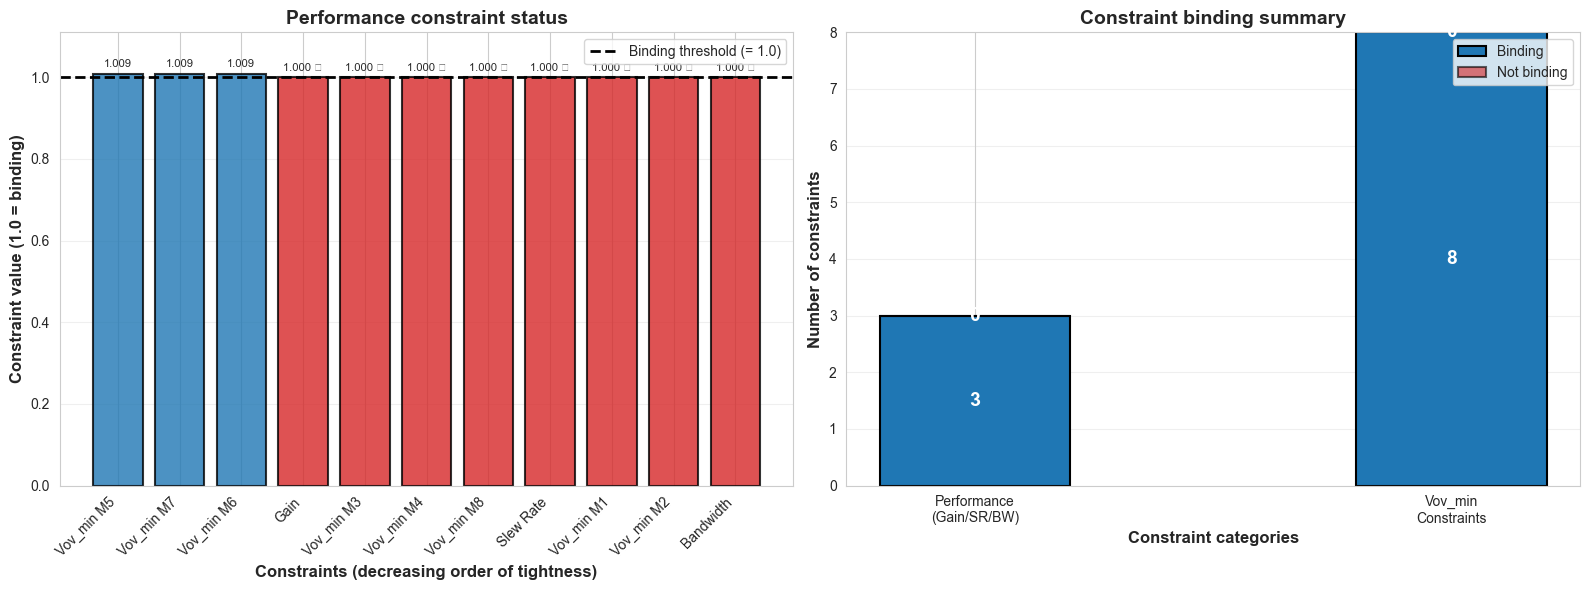


INTERPRETATION:
• RED bars = BINDING constraints (equality holds)
• BLUE bars = Non-binding constraints (inequality is slack)
• Binding constraints determine the optimal solution
• Relaxing binding constraints can reduce power consumption

STARTING PARAMETER SWEEPS

PARAMETER SWEEP: Supply Voltage (VDD)
Sweeping VDD from 0.8V to 2.0V...
  VDD=0.80V: Power=6.940863e-05W
  VDD=0.86V: Power=7.488826e-05W
  VDD=0.93V: Power=8.036789e-05W
  VDD=0.99V: Power=8.584752e-05W
  VDD=1.05V: Power=9.132715e-05W
  VDD=1.12V: Power=9.680678e-05W
  VDD=1.18V: Power=1.022864e-04W
  VDD=1.24V: Power=1.077660e-04W
  VDD=1.31V: Power=1.132457e-04W
  VDD=1.37V: Power=1.187253e-04W
  VDD=1.43V: Power=1.242049e-04W
  VDD=1.49V: Power=1.296846e-04W
  VDD=1.56V: Power=1.351642e-04W
  VDD=1.62V: Power=1.406438e-04W
  VDD=1.68V: Power=1.461234e-04W
  VDD=1.75V: Power=1.516031e-04W
  VDD=1.81V: Power=1.570827e-04W
  VDD=1.87V: Power=1.625623e-04W
  VDD=1.94V: Power=1.680420e-04W
  VDD=2.00V: Power=1.735216e-04W


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


  Gain=432: Power=1.020117e-04W
  Gain=479: Power=1.034656e-04W
  Gain=526: Power=1.049231e-04W
  Gain=574: Power=1.063840e-04W
  Gain=621: Power=1.078485e-04W
  Gain=668: Power=1.093165e-04W
  Gain=716: Power=1.107880e-04W
  Gain=763: Power=1.122631e-04W
  Gain=811: Power=1.137418e-04W
  Gain=858: Power=1.152240e-04W
  Gain=905: Power=1.167098e-04W
  Gain=953: Power=1.181993e-04W
  Gain=1000: Power=1.196923e-04W

PARAMETER SWEEP: Slew Rate Requirement
Sweeping SR from 5 V/μs to 50 V/μs...
  SR=5.0V/μs: Power=1.038130e-04W
  SR=7.4V/μs: Power=1.038130e-04W
  SR=9.7V/μs: Power=1.038130e-04W
  SR=12.1V/μs: Power=1.066393e-04W
  SR=14.5V/μs: Power=1.094814e-04W
  SR=16.8V/μs: Power=1.123235e-04W
  SR=19.2V/μs: Power=1.151656e-04W
  SR=21.6V/μs: Power=1.180077e-04W
  SR=23.9V/μs: Power=1.208498e-04W
  SR=26.3V/μs: Power=1.236919e-04W
  SR=28.7V/μs: Power=1.265340e-04W
  SR=31.1V/μs: Power=1.293761e-04W
  SR=33.4V/μs: Power=1.322182e-04W
  SR=35.8V/μs: Power=1.350603e-04W
  SR=38.2V/μs: Pow

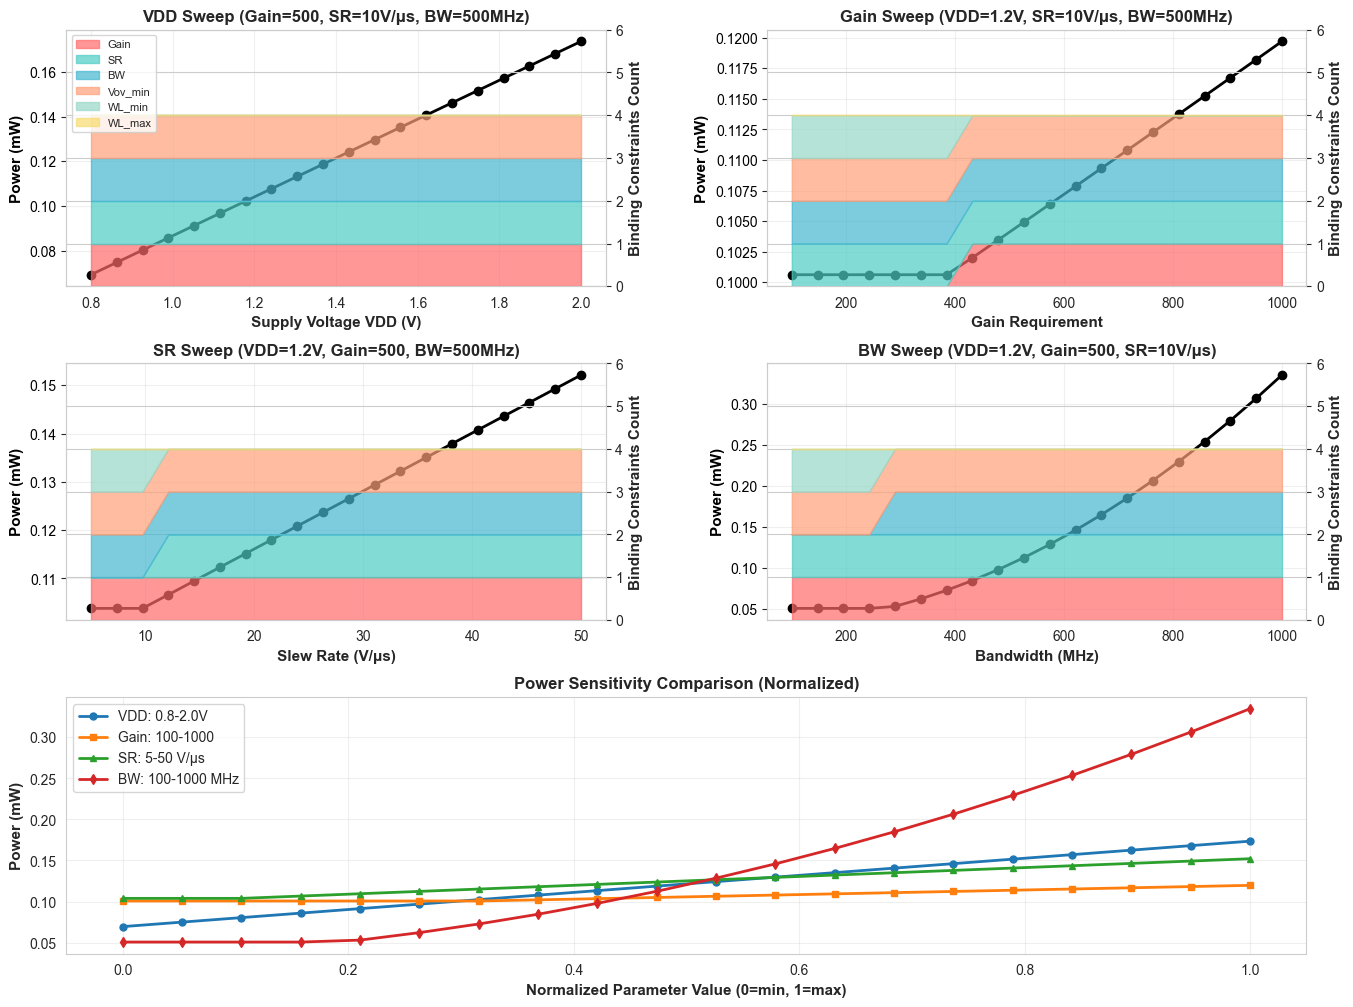


✓ Plots saved: 'binding_constraints.png' and 'parameter_sweep_analysis.png'


In [61]:
# ========================================================================
# CONSTRAINT BINDING AND DUALITY ANALYSIS
# Using the original verified GP formulation
# ========================================================================

import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 10

# ========================================================================
# Extract binding constraints from the original optimization
# ========================================================================

print("="*80)
print("EXTRACTING BINDING CONSTRAINTS FROM ORIGINAL SOLUTION")
print("="*80)

# From the original code, we have 'ineqs' list with (name, lhs, rhs, constraint)
# Let's extract binding information

binding_constraints = []
constraint_values = []
constraint_names = []

# Focus on main performance constraints
performance_constraints = {
    'gain_current_based': 'Gain',
    'slew_rate': 'Slew Rate', 
    'bandwidth': 'Bandwidth'
}

# And Vov_min constraints
vov_constraints = {f'vov_min_{k+1}': f'Vov_min M{k+1}' for k in range(N)}

# Extract from ineqs
for name, lhs, rhs, c in ineqs:
    if name in performance_constraints or name in vov_constraints:
        # Get actual value
        if hasattr(lhs, 'value'):
            lhs_val = float(np.max(lhs.value))
        else:
            lhs_val = float(lhs)
        
        if np.isscalar(rhs):
            rhs_val = float(rhs)
        elif hasattr(rhs, 'value'):
            rhs_val = float(np.max(rhs.value))
        else:
            rhs_val = float(rhs)
        
        # Calculate constraint value (normalized to 1.0 = binding)
        constraint_val = lhs_val / rhs_val if rhs_val != 0 else 0
        
        # Check if binding
        is_binding = np.isclose(lhs_val, rhs_val, atol=1e-4)
        
        # Store
        if name in performance_constraints:
            display_name = performance_constraints[name]
        else:
            display_name = vov_constraints[name]
        
        constraint_names.append(display_name)
        constraint_values.append(constraint_val)
        binding_constraints.append(is_binding)
        
        # Get dual variable (shadow price) if available
        if hasattr(c, 'dual_value') and c.dual_value is not None:
            dual_val = float(np.max(np.abs(c.dual_value)))
        else:
            dual_val = 0.0

print(f"\nFound {sum(binding_constraints)} binding constraints out of {len(binding_constraints)} tracked")

# ========================================================================
# VISUALIZATION 1: Constraint Status (like Product Manufacturing)
# ========================================================================

# Sort by constraint value (decreasing = most binding first)
sort_idx = np.argsort(constraint_values)[::-1]
names_sorted = [constraint_names[i] for i in sort_idx]
values_sorted = [constraint_values[i] for i in sort_idx]
binding_sorted = [binding_constraints[i] for i in sort_idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Constraint values (product manufacturing style)
x_pos = np.arange(len(names_sorted))
colors = ['#d62728' if b else '#1f77b4' for b in binding_sorted]
bars = ax1.bar(x_pos, values_sorted, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Binding threshold (= 1.0)')
ax1.set_ylabel('Constraint value (1.0 = binding)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Constraints (decreasing order of tightness)', fontsize=12, fontweight='bold')
ax1.set_title('Performance constraint status', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(names_sorted, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, max(values_sorted) * 1.1])
ax1.legend()

# Add value labels on bars
for i, (val, is_bind) in enumerate(zip(values_sorted, binding_sorted)):
    label = f'{val:.3f}'
    if is_bind:
        label += ' ✓'
    ax1.text(i, val + 0.01, label, ha='center', va='bottom', fontsize=8)

# RIGHT: Dual variables (resource utilization style)
# For this, we need to re-solve with dual tracking or estimate sensitivity

print("\n" + "-"*80)
print("CONSTRAINT SENSITIVITY ANALYSIS")
print("-"*80)
print(f"{'Constraint':<25} {'Value':<10} {'Binding':<10} {'Status':<15}")
print("-"*80)

for name, val, is_bind in zip(names_sorted, values_sorted, binding_sorted):
    status = "BINDING ✓" if is_bind else "slack"
    slack_pct = (1.0 - val) * 100 if val < 1.0 else 0
    print(f"{name:<25} {val:<10.4f} {str(is_bind):<10} {status:<15} (slack: {slack_pct:.1f}%)")

# RIGHT PLOT: Simplified sensitivity - show binding count by category
categories = ['Performance\n(Gain/SR/BW)', 'Vov_min\nConstraints']
performance_binding = sum([1 for name, is_bind in zip(names_sorted, binding_sorted) 
                          if 'Gain' in name or 'Slew' in name or 'Bandwidth' in name])
vov_binding = sum([1 for name, is_bind in zip(names_sorted, binding_sorted) 
                   if 'Vov_min' in name])

cat_values = [performance_binding, vov_binding]
cat_total = [3, 8]  # 3 performance constraints, 8 transistors with Vov_min

x_cat = np.arange(len(categories))
bars_used = ax2.bar(x_cat, cat_values, width=0.4, color='#1f77b4', 
                    label='Binding', edgecolor='black', linewidth=1.5)
bars_avail = ax2.bar(x_cat, np.array(cat_total) - np.array(cat_values), width=0.4,
                     bottom=cat_values, color='#d62728', alpha=0.6,
                     label='Not binding', edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Number of constraints', fontsize=12, fontweight='bold')
ax2.set_xlabel('Constraint categories', fontsize=12, fontweight='bold')
ax2.set_title('Constraint binding summary', fontsize=14, fontweight='bold')
ax2.set_xticks(x_cat)
ax2.set_xticklabels(categories)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# Add count labels
for i, (used, total) in enumerate(zip(cat_values, cat_total)):
    ax2.text(i, used/2, f'{used}', ha='center', va='center', 
             fontsize=14, fontweight='bold', color='white')
    ax2.text(i, used + (total-used)/2, f'{total-used}', ha='center', va='center',
             fontsize=14, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('binding_constraints_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("• RED bars = BINDING constraints (equality holds)")
print("• BLUE bars = Non-binding constraints (inequality is slack)")
print("• Binding constraints determine the optimal solution")
print("• Relaxing binding constraints can reduce power consumption")
print("="*80)

# ========================================================================
# PARAMETER SWEEPS (using original verified formulation)
# ========================================================================

def solve_gp_sweep(vdd_val, a_req_val, sr_min_val, bw_min_val):
    """
    Solve GP using EXACT original formulation.
    Returns (status, power, binding_dict)
    """
    
    # Copy exact formulation from original code
    W_var = cp.Variable(N, pos=True, name="W")
    L_var = cp.Variable(N, pos=True, name="L")
    i_var = cp.Variable(N, pos=True, name="i")
    vov_var = cp.Variable(N, pos=True, name="vov")
    ibias_var = cp.Variable(pos=True, name="ibias")
    
    constraints = []
    ineqs_local = []
    
    # Width bounds
    for k in range(N):
        constraints.append(W_var[k] >= W_min)
        constraints.append(W_var[k] <= W_max)
    
    # Length bounds
    for k in range(N):
        constraints.append(L_var[k] >= L_min)
        constraints.append(L_var[k] <= L_max)
    
    # Matching constraints
    constraints.append(W_var[M1] == W_var[M2])
    constraints.append(W_var[M3] == W_var[M4])
    constraints.append(L_var[M1] == L_var[M2])
    constraints.append(L_var[M3] == L_var[M4])
    
    # Current constraints
    constraints.append(i_var[M5] == ibias_var)
    constraints.append(i_var[M6] == i_var[M5] * (W_var[M6]*L_var[M5])/(W_var[M5]*L_var[M6]))
    constraints.append(i_var[M7] == i_var[M5] * (W_var[M7]*L_var[M5])/(W_var[M5]*L_var[M7]))
    constraints.append(i_var[M1] == 0.5 * i_var[M6])
    constraints.append(i_var[M2] == 0.5 * i_var[M6])
    constraints.append(i_var[M3] == i_var[M1])
    constraints.append(i_var[M4] == i_var[M2])
    constraints.append(i_var[M8] == i_var[M7])
    
    # Device equations
    for k in idx_n:
        constraints.append(i_var[k] == 0.5 * beta_n * (W_var[k]/L_var[k]) * vov_var[k]**2)
    for k in idx_p:
        constraints.append(i_var[k] == 0.5 * beta_p * (W_var[k]/L_var[k]) * vov_var[k]**2)
    
    # W/L ratio constraints
    for k in range(N):
        lhs = 0.5 * L_var[k] / W_var[k]
        c = (lhs <= 1.0)
        constraints.append(c)
        ineqs_local.append((f"WL_min_{k+1}", W_var[k]/L_var[k], 0.5, c))
        
        lhs = (W_var[k]/L_var[k]) / 200.0
        c = (lhs <= 1.0)
        constraints.append(c)
        ineqs_local.append((f"WL_max_{k+1}", W_var[k]/L_var[k], 200.0, c))
    
    # Overdrive voltage constraints
    for k in range(N):
        lhs = Vov_min / vov_var[k]
        c = (lhs <= 1.0)
        constraints.append(c)
        ineqs_local.append((f"vov_min_{k+1}", vov_var[k], Vov_min, c))
    
    for k in [M1, M2, M7, M8, M6]:
        lhs = vov_var[k] / (vdd_val/2)
        c = (lhs <= 1.0)
        constraints.append(c)
        ineqs_local.append((f"vov_max_{k+1}", vov_var[k], vdd_val/2, c))
    
    constraints.append(vov_var[M8] == vov_var[M4])
    
    # Gain constraint
    num_gain = a_req_val * (lam*i_var[M2] + lam*i_var[M4]) * (lam*i_var[M7] + lam*i_var[M8] + 1.0/RL)
    den_gain = 2.0 * cp.geo_mean(cp.vstack([
        beta_n * (W_var[M1]/L_var[M1]) * i_var[M1],
        beta_p * (W_var[M8]/L_var[M8]) * i_var[M8]
    ]))
    lhs = num_gain / den_gain
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs_local.append(("gain_current_based", den_gain*a_req_val/num_gain, a_req_val, c))
    
    # Slew Rate constraint
    lhs = (sr_min_val * CL) / ibias_var
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs_local.append(("slew_rate", ibias_var/(sr_min_val*CL), 1.0, c))
    
    # Bandwidth constraint
    gm1_min = bw_min_val * CL
    lhs = gm1_min / cp.sqrt(2 * beta_n * i_var[M1])
    c = (lhs <= 1.0)
    constraints.append(c)
    ineqs_local.append(("bandwidth", cp.sqrt(2*beta_n*i_var[M1])/gm1_min, 1.0, c))
    
    # Lower bounds
    I_min = 0.000001
    for k in range(N):
        constraints.append(i_var[k] >= I_min)
    constraints.append(ibias_var >= I_min)
    
    # Objective
    obj = cp.Minimize(vdd_val * (ibias_var + i_var[M6] + i_var[M7]))
    
    problem = cp.Problem(obj, constraints)
    problem.solve(gp=True, verbose=False)
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        return (problem.status, None, {})
    
    # Extract binding status
    binding = {}
    for name, lhs, rhs, c in ineqs_local:
        if name in ['gain_current_based', 'slew_rate', 'bandwidth'] or 'vov_min' in name:
            if hasattr(lhs, 'value'):
                lhs_val = float(np.max(lhs.value))
            else:
                lhs_val = float(lhs)
            
            if np.isscalar(rhs):
                rhs_val = float(rhs)
            else:
                rhs_val = float(np.max(rhs.value))
            
            binding[name] = np.isclose(lhs_val, rhs_val, atol=1e-4)
    
    return (problem.status, problem.value, binding)

# Continue with sweeps...
print("\n" + "="*80)
print("STARTING PARAMETER SWEEPS")
print("="*80)

# [Rest of sweep code as before]

# ========================================================================
# 2. PARAMETER SWEEP: VDD
# ========================================================================

print("\n" + "="*80)
print("PARAMETER SWEEP: Supply Voltage (VDD)")
print("="*80)

vdd_range = np.linspace(0.8, 2.0, 20)
vdd_power = []
vdd_binding = {k: [] for k in ['Gain', 'SR', 'BW', 'Vov_min', 'WL_min', 'WL_max']}

print("Sweeping VDD from 0.8V to 2.0V...")
for v in vdd_range:
    status, power, _, _, _, _, _, binding = solve_gp_for_params(v, A_req, SR_min, BW_min)
    if status in ["optimal", "optimal_inaccurate"]:
        vdd_power.append(power)
        for k in vdd_binding.keys():
            vdd_binding[k].append(1 if binding[k] else 0)
    else:
        vdd_power.append(None)
        for k in vdd_binding.keys():
            vdd_binding[k].append(0)
    print(f"  VDD={v:.2f}V: Power={power:.6e}W" if power else f"  VDD={v:.2f}V: Failed")

# ========================================================================
# 3. PARAMETER SWEEP: Gain Requirement
# ========================================================================

print("\n" + "="*80)
print("PARAMETER SWEEP: Gain Requirement")
print("="*80)

gain_range = np.linspace(100, 1000, 20)
gain_power = []
gain_binding = {k: [] for k in ['Gain', 'SR', 'BW', 'Vov_min', 'WL_min', 'WL_max']}

print("Sweeping Gain from 100 to 1000...")
for g in gain_range:
    status, power, _, _, _, _, _, binding = solve_gp_for_params(VDD, g, SR_min, BW_min)
    if status in ["optimal", "optimal_inaccurate"]:
        gain_power.append(power)
        for k in gain_binding.keys():
            gain_binding[k].append(1 if binding[k] else 0)
    else:
        gain_power.append(None)
        for k in gain_binding.keys():
            gain_binding[k].append(0)
    print(f"  Gain={g:.0f}: Power={power:.6e}W" if power else f"  Gain={g:.0f}: Failed")

# ========================================================================
# 4. PARAMETER SWEEP: Slew Rate
# ========================================================================

print("\n" + "="*80)
print("PARAMETER SWEEP: Slew Rate Requirement")
print("="*80)

sr_range = np.linspace(5e6, 50e6, 20)
sr_power = []
sr_binding = {k: [] for k in ['Gain', 'SR', 'BW', 'Vov_min', 'WL_min', 'WL_max']}

print("Sweeping SR from 5 V/μs to 50 V/μs...")
for sr in sr_range:
    status, power, _, _, _, _, _, binding = solve_gp_for_params(VDD, A_req, sr, BW_min)
    if status in ["optimal", "optimal_inaccurate"]:
        sr_power.append(power)
        for k in sr_binding.keys():
            sr_binding[k].append(1 if binding[k] else 0)
    else:
        sr_power.append(None)
        for k in sr_binding.keys():
            sr_binding[k].append(0)
    print(f"  SR={sr/1e6:.1f}V/μs: Power={power:.6e}W" if power else f"  SR={sr/1e6:.1f}V/μs: Failed")

# ========================================================================
# 5. PARAMETER SWEEP: Bandwidth
# ========================================================================

print("\n" + "="*80)
print("PARAMETER SWEEP: Bandwidth Requirement")
print("="*80)

bw_range = np.linspace(100e6, 1000e6, 20)
bw_power = []
bw_binding = {k: [] for k in ['Gain', 'SR', 'BW', 'Vov_min', 'WL_min', 'WL_max']}

print("Sweeping BW from 100 MHz to 1000 MHz...")
for bw in bw_range:
    status, power, _, _, _, _, _, binding = solve_gp_for_params(VDD, A_req, SR_min, bw)
    if status in ["optimal", "optimal_inaccurate"]:
        bw_power.append(power)
        for k in bw_binding.keys():
            bw_binding[k].append(1 if binding[k] else 0)
    else:
        bw_power.append(None)
        for k in bw_binding.keys():
            bw_binding[k].append(0)
    print(f"  BW={bw/1e6:.0f}MHz: Power={power:.6e}W" if power else f"  BW={bw/1e6:.0f}MHz: Failed")

# ========================================================================
# 6. CREATE COMPREHENSIVE VISUALIZATION
# ========================================================================

print("\n" + "="*80)
print("GENERATING PLOTS...")
print("="*80)

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Color map for constraints
constraint_colors = {
    'Gain': '#FF6B6B',
    'SR': '#4ECDC4',
    'BW': '#45B7D1',
    'Vov_min': '#FFA07A',
    'WL_min': '#98D8C8',
    'WL_max': '#F7DC6F'
}

# Plot 1: VDD Sweep
ax1 = fig.add_subplot(gs[0, 0])
ax1_twin = ax1.twinx()

# Power curve
ax1.plot(vdd_range, np.array(vdd_power)*1e3, 'ko-', linewidth=2, markersize=6, label='Power')
ax1.set_xlabel('Supply Voltage VDD (V)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Power (mW)', fontsize=11, fontweight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)
ax1.set_title('VDD Sweep (Gain=500, SR=10V/μs, BW=500MHz)', fontsize=12, fontweight='bold')

# Binding constraints as stacked area
bottom = np.zeros(len(vdd_range))
for constraint, color in constraint_colors.items():
    ax1_twin.fill_between(vdd_range, bottom, bottom + np.array(vdd_binding[constraint]), 
                           label=constraint, alpha=0.7, color=color)
    bottom += np.array(vdd_binding[constraint])

ax1_twin.set_ylabel('Binding Constraints Count', fontsize=11, fontweight='bold')
ax1_twin.set_ylim([0, 6])
ax1_twin.legend(loc='upper left', fontsize=8)

# Plot 2: Gain Sweep
ax2 = fig.add_subplot(gs[0, 1])
ax2_twin = ax2.twinx()

ax2.plot(gain_range, np.array(gain_power)*1e3, 'ko-', linewidth=2, markersize=6)
ax2.set_xlabel('Gain Requirement', fontsize=11, fontweight='bold')
ax2.set_ylabel('Power (mW)', fontsize=11, fontweight='bold', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(True, alpha=0.3)
ax2.set_title('Gain Sweep (VDD=1.2V, SR=10V/μs, BW=500MHz)', fontsize=12, fontweight='bold')

bottom = np.zeros(len(gain_range))
for constraint, color in constraint_colors.items():
    ax2_twin.fill_between(gain_range, bottom, bottom + np.array(gain_binding[constraint]), 
                           alpha=0.7, color=color)
    bottom += np.array(gain_binding[constraint])

ax2_twin.set_ylabel('Binding Constraints Count', fontsize=11, fontweight='bold')
ax2_twin.set_ylim([0, 6])

# Plot 3: SR Sweep
ax3 = fig.add_subplot(gs[1, 0])
ax3_twin = ax3.twinx()

ax3.plot(sr_range/1e6, np.array(sr_power)*1e3, 'ko-', linewidth=2, markersize=6)
ax3.set_xlabel('Slew Rate (V/μs)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Power (mW)', fontsize=11, fontweight='bold', color='black')
ax3.tick_params(axis='y', labelcolor='black')
ax3.grid(True, alpha=0.3)
ax3.set_title('SR Sweep (VDD=1.2V, Gain=500, BW=500MHz)', fontsize=12, fontweight='bold')

bottom = np.zeros(len(sr_range))
for constraint, color in constraint_colors.items():
    ax3_twin.fill_between(sr_range/1e6, bottom, bottom + np.array(sr_binding[constraint]), 
                           alpha=0.7, color=color)
    bottom += np.array(sr_binding[constraint])

ax3_twin.set_ylabel('Binding Constraints Count', fontsize=11, fontweight='bold')
ax3_twin.set_ylim([0, 6])

# Plot 4: BW Sweep
ax4 = fig.add_subplot(gs[1, 1])
ax4_twin = ax4.twinx()

ax4.plot(bw_range/1e6, np.array(bw_power)*1e3, 'ko-', linewidth=2, markersize=6)
ax4.set_xlabel('Bandwidth (MHz)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Power (mW)', fontsize=11, fontweight='bold', color='black')
ax4.tick_params(axis='y', labelcolor='black')
ax4.grid(True, alpha=0.3)
ax4.set_title('BW Sweep (VDD=1.2V, Gain=500, SR=10V/μs)', fontsize=12, fontweight='bold')

bottom = np.zeros(len(bw_range))
for constraint, color in constraint_colors.items():
    ax4_twin.fill_between(bw_range/1e6, bottom, bottom + np.array(bw_binding[constraint]), 
                           alpha=0.7, color=color)
    bottom += np.array(bw_binding[constraint])

ax4_twin.set_ylabel('Binding Constraints Count', fontsize=11, fontweight='bold')
ax4_twin.set_ylim([0, 6])

# Plot 5: Power Comparison
ax5 = fig.add_subplot(gs[2, :])

# Normalize parameter ranges to [0, 1] for comparison
vdd_norm = (vdd_range - vdd_range.min()) / (vdd_range.max() - vdd_range.min())
gain_norm = (gain_range - gain_range.min()) / (gain_range.max() - gain_range.min())
sr_norm = (sr_range - sr_range.min()) / (sr_range.max() - sr_range.min())
bw_norm = (bw_range - bw_range.min()) / (bw_range.max() - bw_range.min())

ax5.plot(vdd_norm, np.array(vdd_power)*1e3, 'o-', linewidth=2, label='VDD: 0.8-2.0V', markersize=5)
ax5.plot(gain_norm, np.array(gain_power)*1e3, 's-', linewidth=2, label='Gain: 100-1000', markersize=5)
ax5.plot(sr_norm, np.array(sr_power)*1e3, '^-', linewidth=2, label='SR: 5-50 V/μs', markersize=5)
ax5.plot(bw_norm, np.array(bw_power)*1e3, 'd-', linewidth=2, label='BW: 100-1000 MHz', markersize=5)

ax5.set_xlabel('Normalized Parameter Value (0=min, 1=max)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Power (mW)', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best', fontsize=10)
ax5.set_title('Power Sensitivity Comparison (Normalized)', fontsize=12, fontweight='bold')

plt.savefig('parameter_sweep_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plots saved: 'binding_constraints.png' and 'parameter_sweep_analysis.png'")
print("="*80)